# *Library and file dependancies*

In [2]:

# Single cell 
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# CLustering 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import fowlkes_mallows_score
# Scaling 
from sklearn.preprocessing import StandardScaler
#Optimization
import optuna
# Output control
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

In [3]:
from utils.optimization import optimizeGMM
from scGmix import scgmix

In [4]:
adata = sc.read('datasets/dimreduced_cellcounts.h5ad')

# **Researchers' cancer/non-cancer cell seperation results**

For the seperation of cancer with non-cancer cells the researchers used the chromosomal gene
expression patterns identified from moving averages of 150 genes. From the PCA representation we have the intuition thats it possible to seperate cancer, non-cancer cells directly from the counts matrix. Given this insight, clustering is applied directly to the sc-Dataset. The initial step involves loading the cluster labels inferred by the researchers to compare them with our own methodology.

In [5]:
df = pd.read_csv("datasets/GSE75688_final_sample_information.txt", delimiter="\t")
df_sorted = df.sort_values(by='sample', ascending=True)
df_sorted = pd.concat([df[df['sample'].str.split('_', expand=True)[1] == 'Pooled'],
                      df[df['sample'].str.split('_', expand=True)[1] != 'Pooled']])

pooled_names = df.loc[df['sample'].str.contains('_Pooled'), 'sample']

mask = df['sample'].isin(pooled_names)

sorted_lines = df[mask].sort_values(by='sample')

df_sorted = pd.concat([sorted_lines, df[~mask]])
# rename the BC07_Pooled as BC07_Tumor
df_sorted.loc[129, 'sample'] = 'BC07_Tumor'

bulk_rows = df_sorted[df_sorted['type'] == "Bulk"]
rest_rows = df_sorted[df_sorted['type'] != "Bulk"]

df_sorted.head()

sample  type  index index2 index3
22     BC01_Pooled  Bulk  Tumor  Tumor  Tumor
419    BC02_Pooled  Bulk  Tumor  Tumor  Tumor
270  BC03LN_Pooled  Bulk  Tumor  Tumor  Tumor
216    BC03_Pooled  Bulk  Tumor  Tumor  Tumor
78     BC04_Pooled  Bulk  Tumor  Tumor  Tumor

As evident from the results below, our adata object contains 9 additional cells compared to the researchers' dataset. This result arises from the implementation of our custom preprocessing pipeline. 

In [6]:
set1 = set(rest_rows['sample'])
set2 = set(adata.obs_names)
diff = set2 - set1
print(f"Our dataset contains these extra cells: {diff}")
adata = adata[~adata.obs_names.isin(diff), :]

Our dataset contains these extra cells: {'BC04_06', 'BC07LN_20', 'BC06_22', 'BC04_05', 'BC08_12', 'BC09_Re_72', 'BC05_40', 'BC06_09', 'BC04_25'}


In [7]:
# Create a mapping dictionary from rest_rows
mapping_class = rest_rows.set_index('sample')['index'].to_dict()
mapping_type = rest_rows.set_index('sample')['index2'].to_dict()
mapping_spec = rest_rows.set_index('sample')['index3'].to_dict()

adata.obs['Ground labels'] = adata.obs_names.map(mapping_class)
adata.obs['type'] = adata.obs_names.map(mapping_type)
adata.obs['spec'] = adata.obs_names.map(mapping_spec)

Below we plot the clustering for cancer/non-cancer cell seperation results of the researchers utilizing a PCA,TSNE AND UMAP representation.

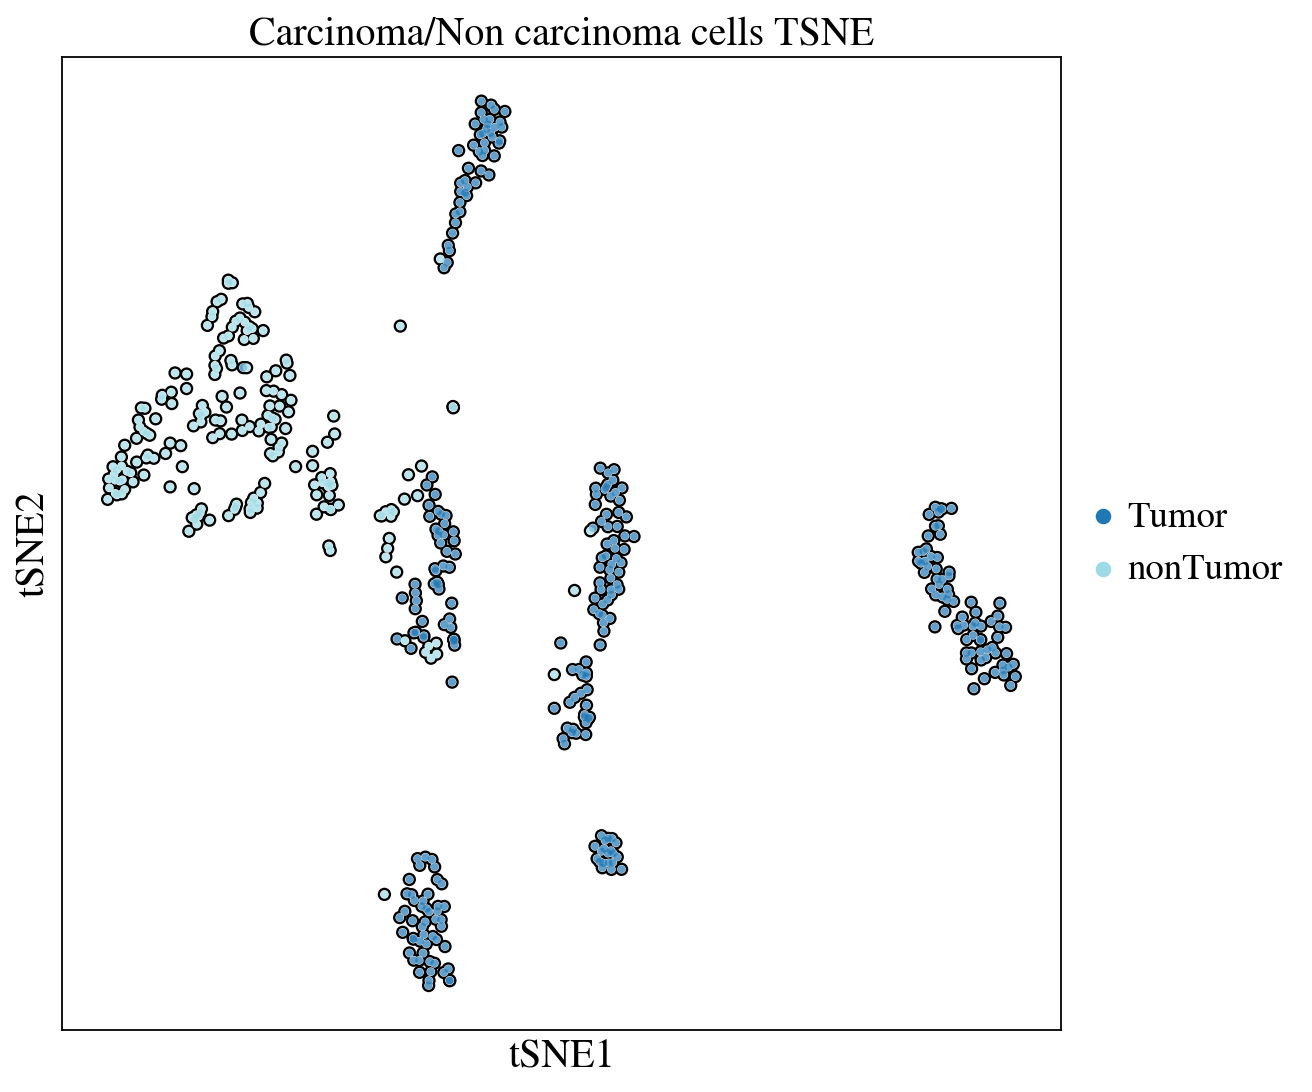

In [8]:
sc.pl.tsne(adata, color="Ground labels", title='Carcinoma/Non carcinoma cells TSNE', add_outline=True, size = 50,palette = "tab20")

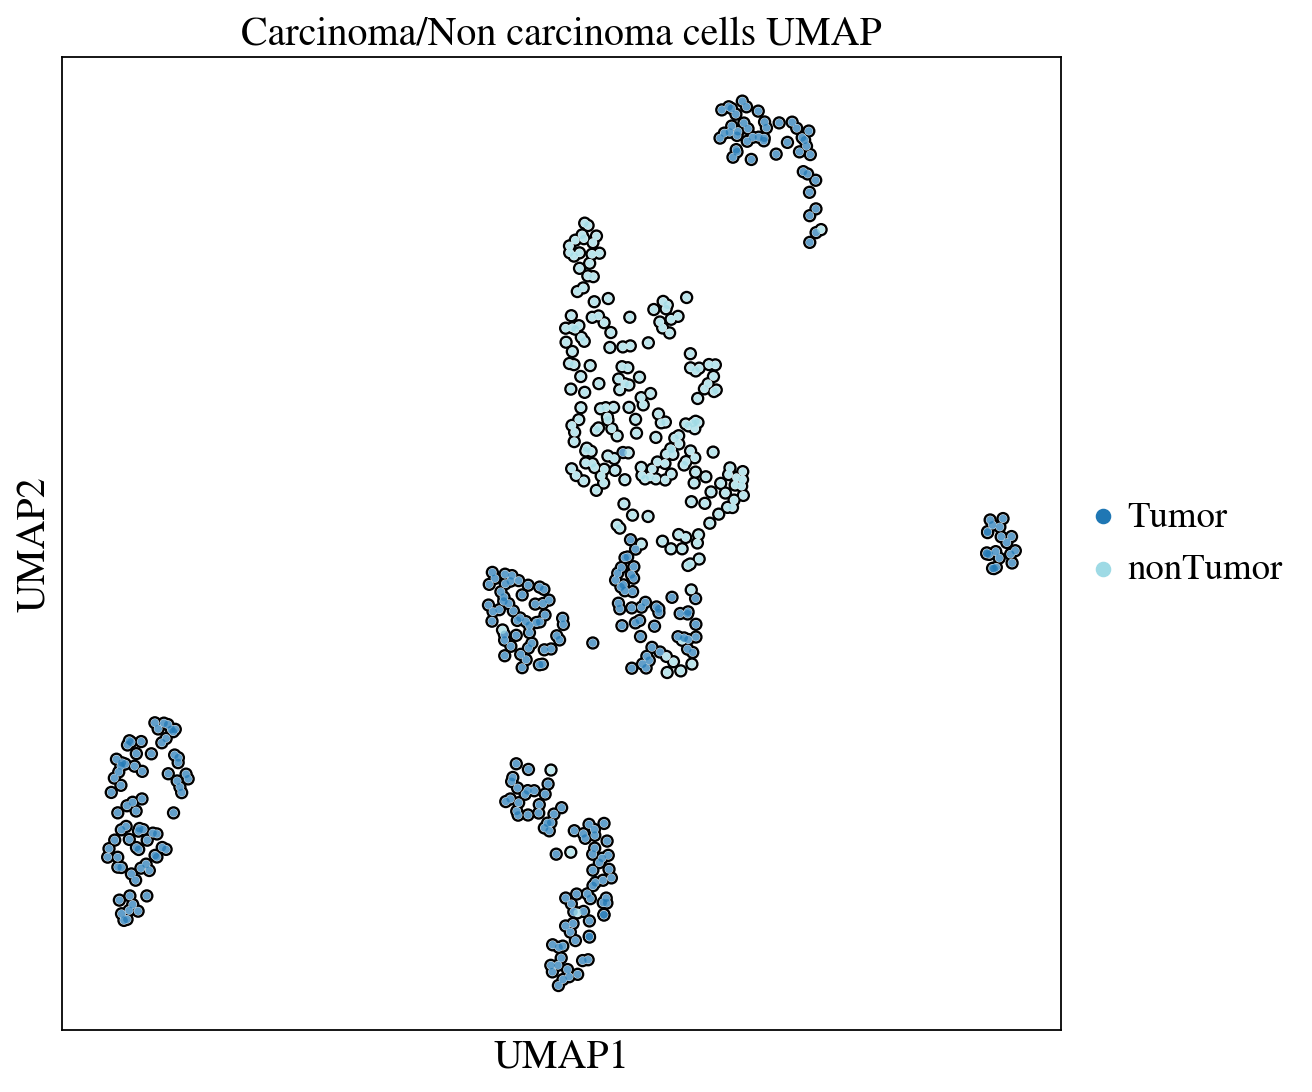

In [9]:
sc.pl.umap(adata, color="Ground labels", title='Carcinoma/Non carcinoma cells UMAP', add_outline=True, size = 50,palette = "tab20")

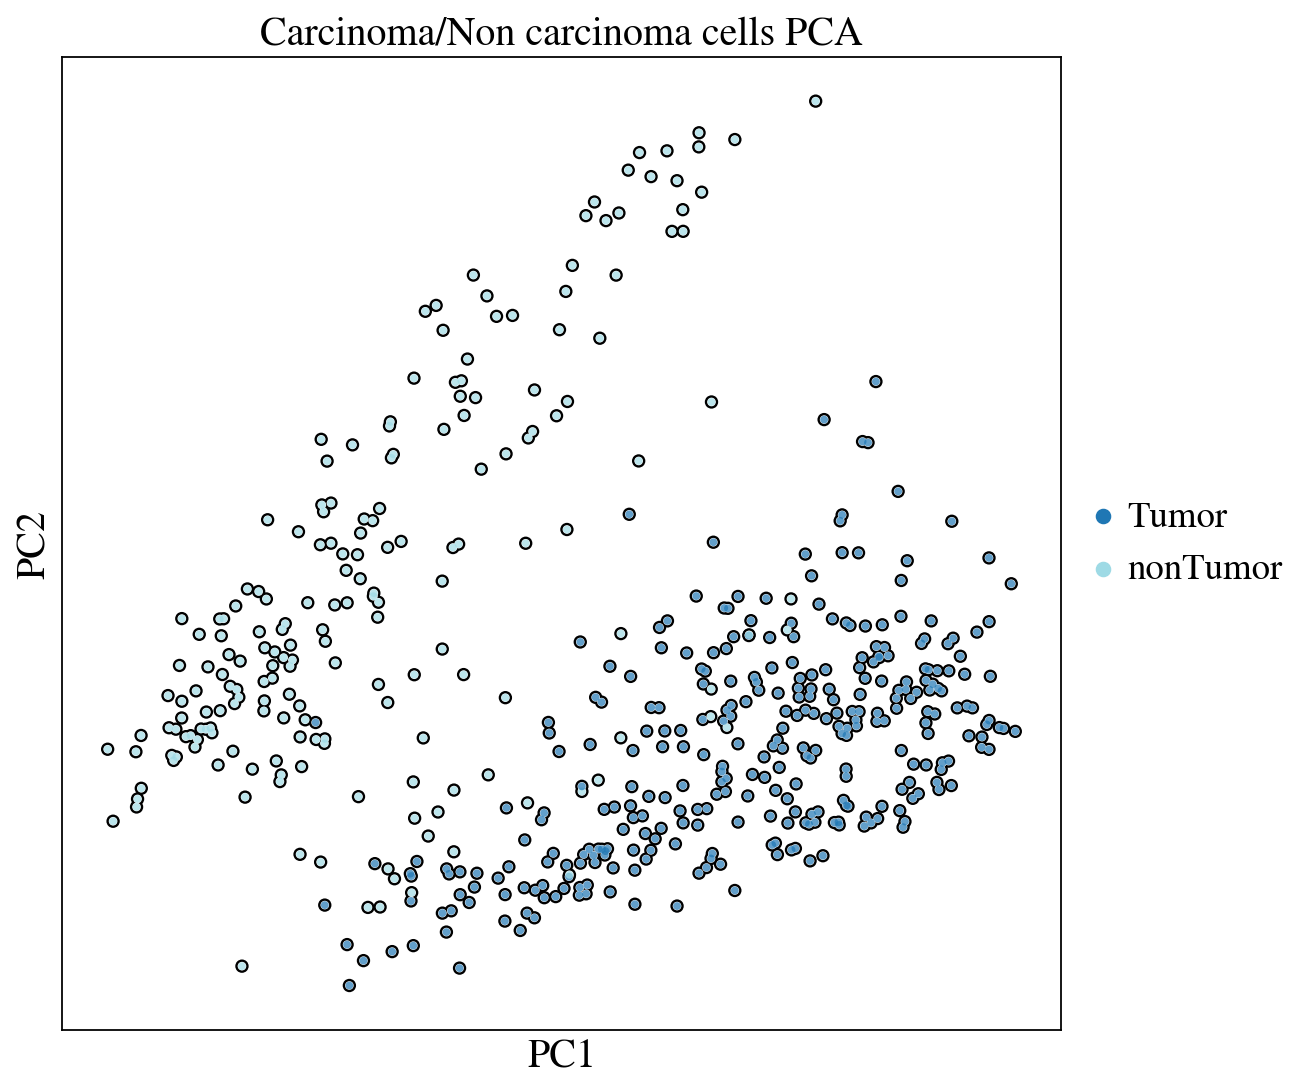

In [10]:
sc.pl.pca(adata, color="Ground labels", title='Carcinoma/Non carcinoma cells PCA', add_outline=True, size = 50,palette = "tab20")

From the above we can verify our hypothesis that non-tumour cells lie in a distinct cluster.

## Evaluating the researchers' clustering results in the PCA space

For clustering evaluation without ground truth labels we utilize the silhouete score: $$s(i) = \frac{{b(i) - a(i)}}{{\max(a(i), b(i))}}$$
which measures the average fitness of how well each sample fits within its assigned cluster:
- A score close to 1 indicates that the sample is well-matched to its own cluster and poorly-matched to neighboring clusters. This suggests a good separation between clusters.
- A score close to 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
- A score close to -1 indicates that the sample is likely assigned to the wrong cluster, as it is more similar to samples in a neighboring cluster than to samples in its own cluster.

In [11]:
data = adata.obsm['X_pca']
ground_labels = adata.obs['Ground labels']
score = silhouette_score(data,ground_labels)
print(f"The silhouete score in the PCA space is: {score}")

The silhouete score in the PCA space is: 0.1348501294851303


# **Our CLustering methodology for cancer/non-cancer cell seperation**

In order to compare our clustering results with the ground labels of the researchers we utilized three additional metrics:

The adjusted for chance rand index (ARI):

$$RI = \frac{\text{number of agreeing pairs}}{\text{number of pairs}}$$
$$ARI = (\text{RI} - \text{E}[\text{RI}] ) / (max(RI) - Expected_RI) $$

### **Hierarchical: Average linkage**

The silhouete score in the optimal PCA space is: 0.23388658463954926
The adjusted random index (ARI) score with the original labels is: 0.0024496192405428405
The adjusted mutual information (AMI) score with to the original labels is: 0.0017466154601578497
The fowlkes mallows score with the original labels is: 0.7255439567547814


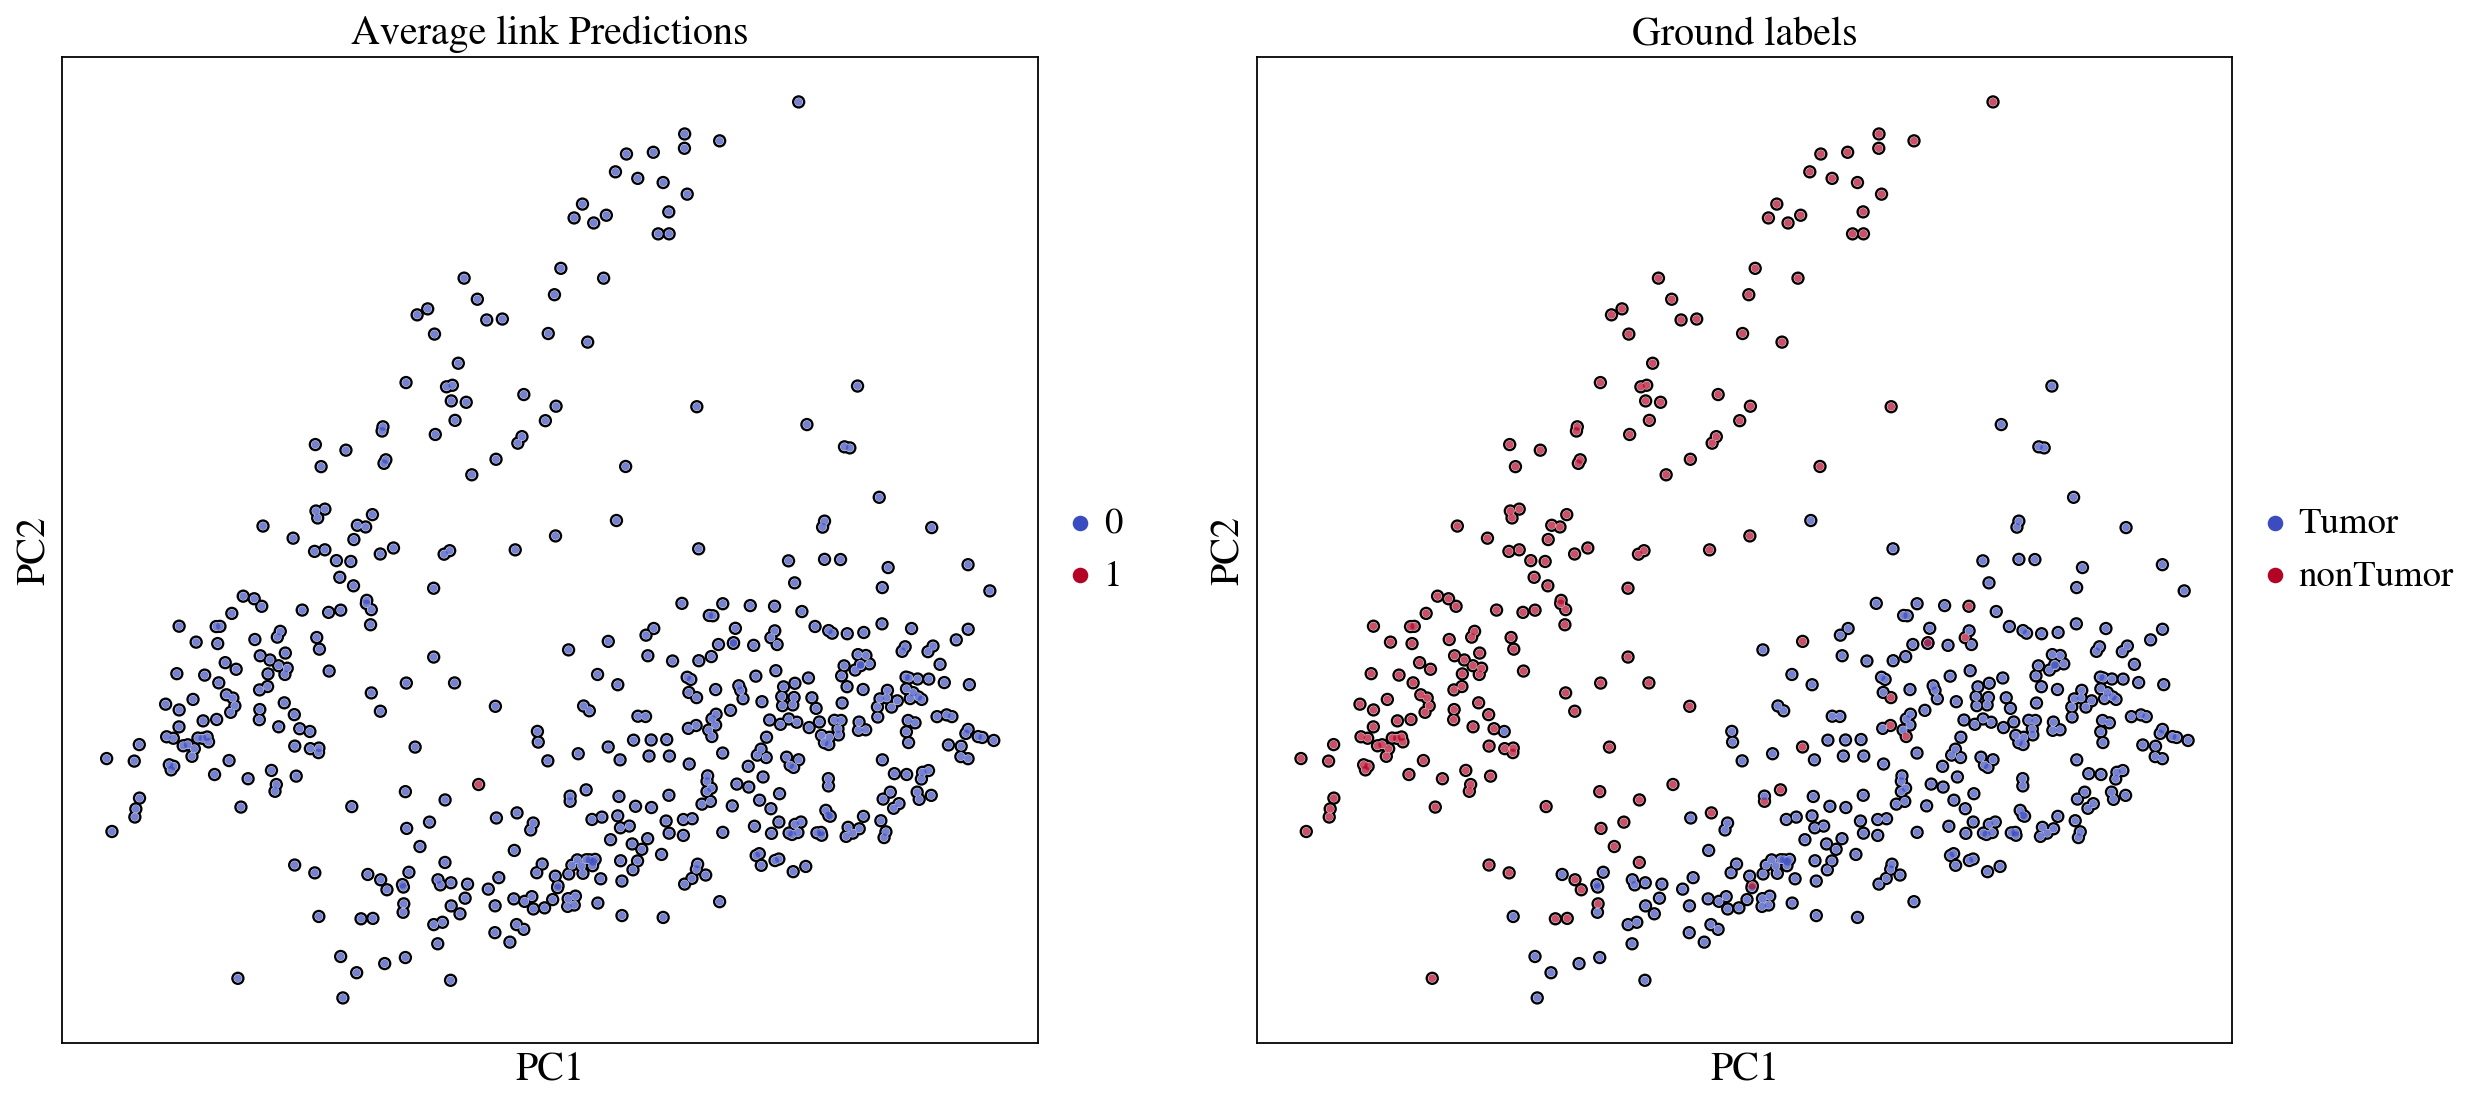

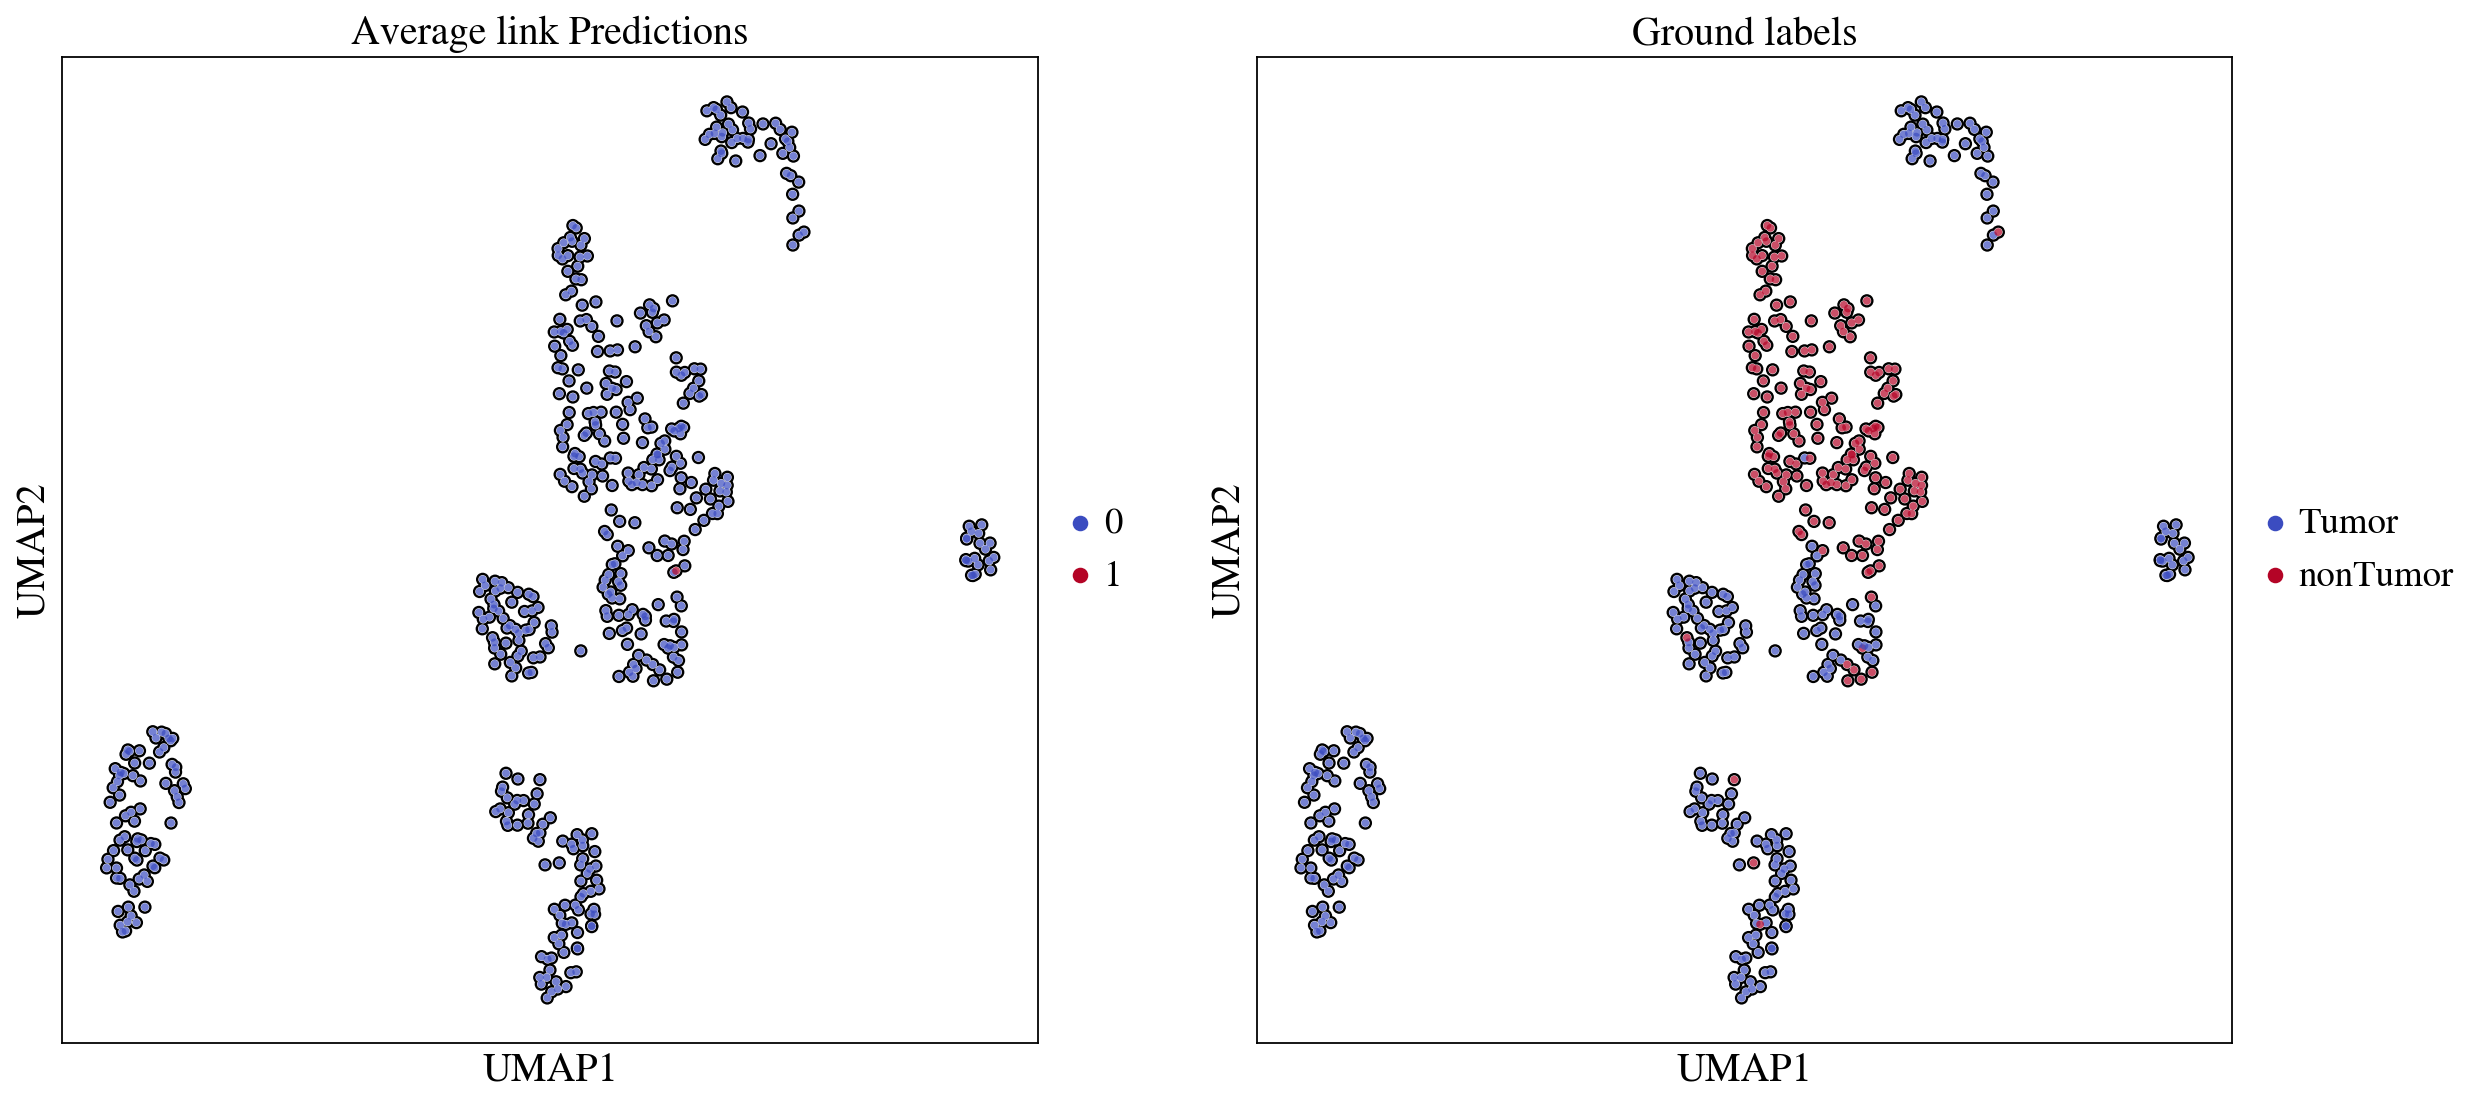

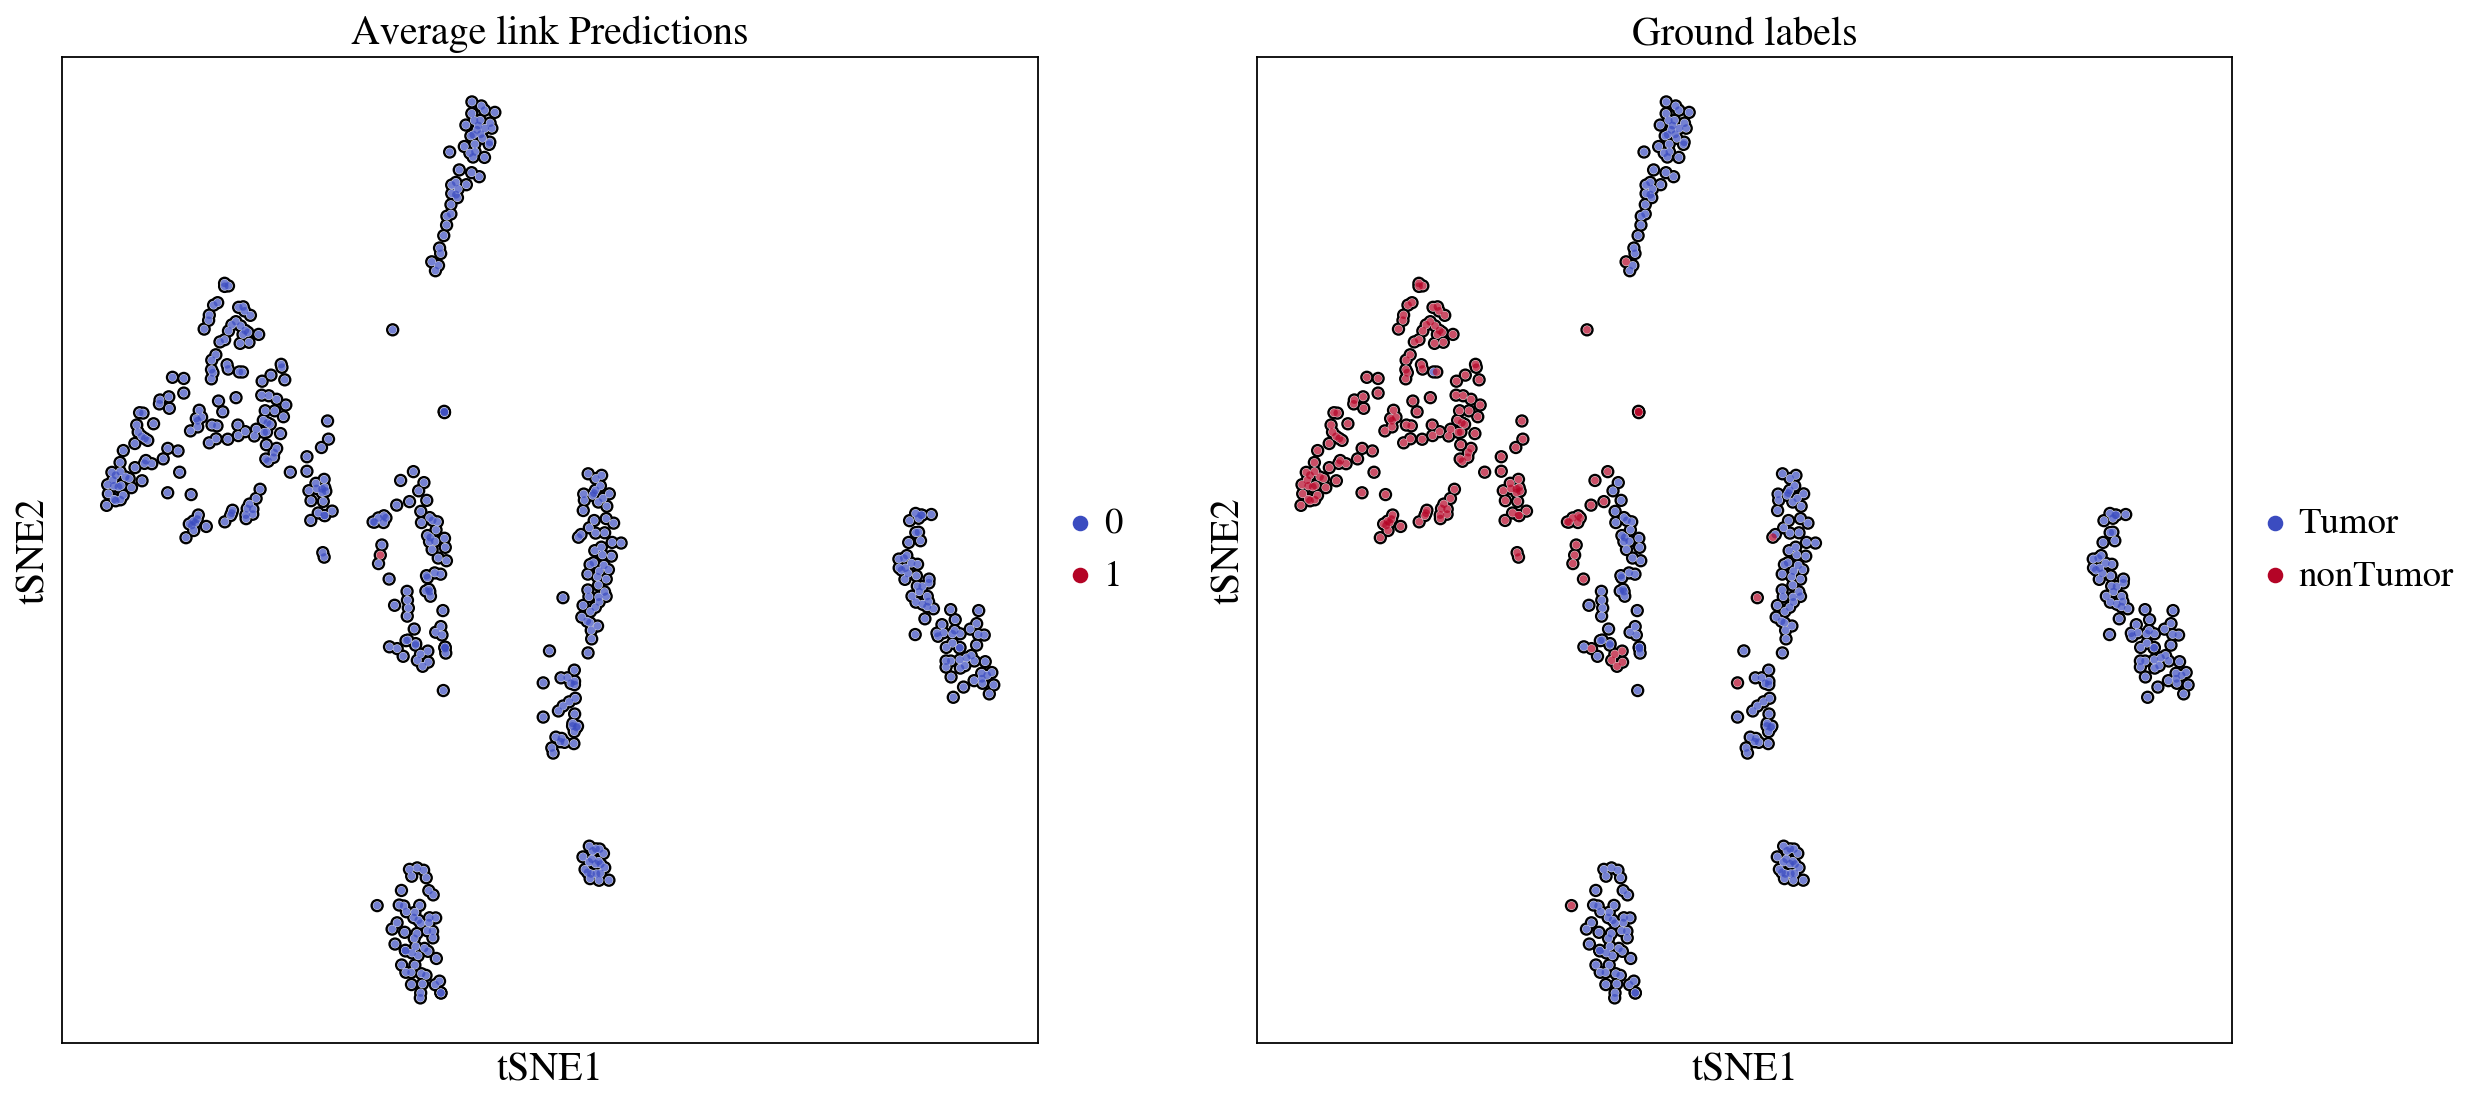

In [12]:

model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
labels = model.fit_predict(data)
ha_score = silhouette_score(data,labels)
ha_ari = adjusted_rand_score(ground_labels, labels)
ha_ami = adjusted_mutual_info_score(ground_labels, labels)
ha_fow = fowlkes_mallows_score(ground_labels,labels)
print(f"The silhouete score in the optimal PCA space is: {ha_score}")
print(f"The adjusted random index (ARI) score with the original labels is: {ha_ari}")
print(f"The adjusted mutual information (AMI) score with to the original labels is: {ha_ami}")
print(f"The fowlkes mallows score with the original labels is: {ha_fow}")

adata.obs['Average link Predictions'] = labels.astype(str)

sc.pl.pca(adata, color=["Average link Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.umap(adata, color=["Average link Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.tsne(adata, color=["Average link Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")

### **Hierarchical: Ward linkage**

The silhouete score in the optimal PCA space is: 0.13933494687080383
The adjusted random index (ARI) score with the original labels is: 0.8923804494549771
The adjusted mutual information (AMI) score with to the original labels is: 0.8174886603460602
The fowlkes mallows score with the original labels is: 0.949584236306355


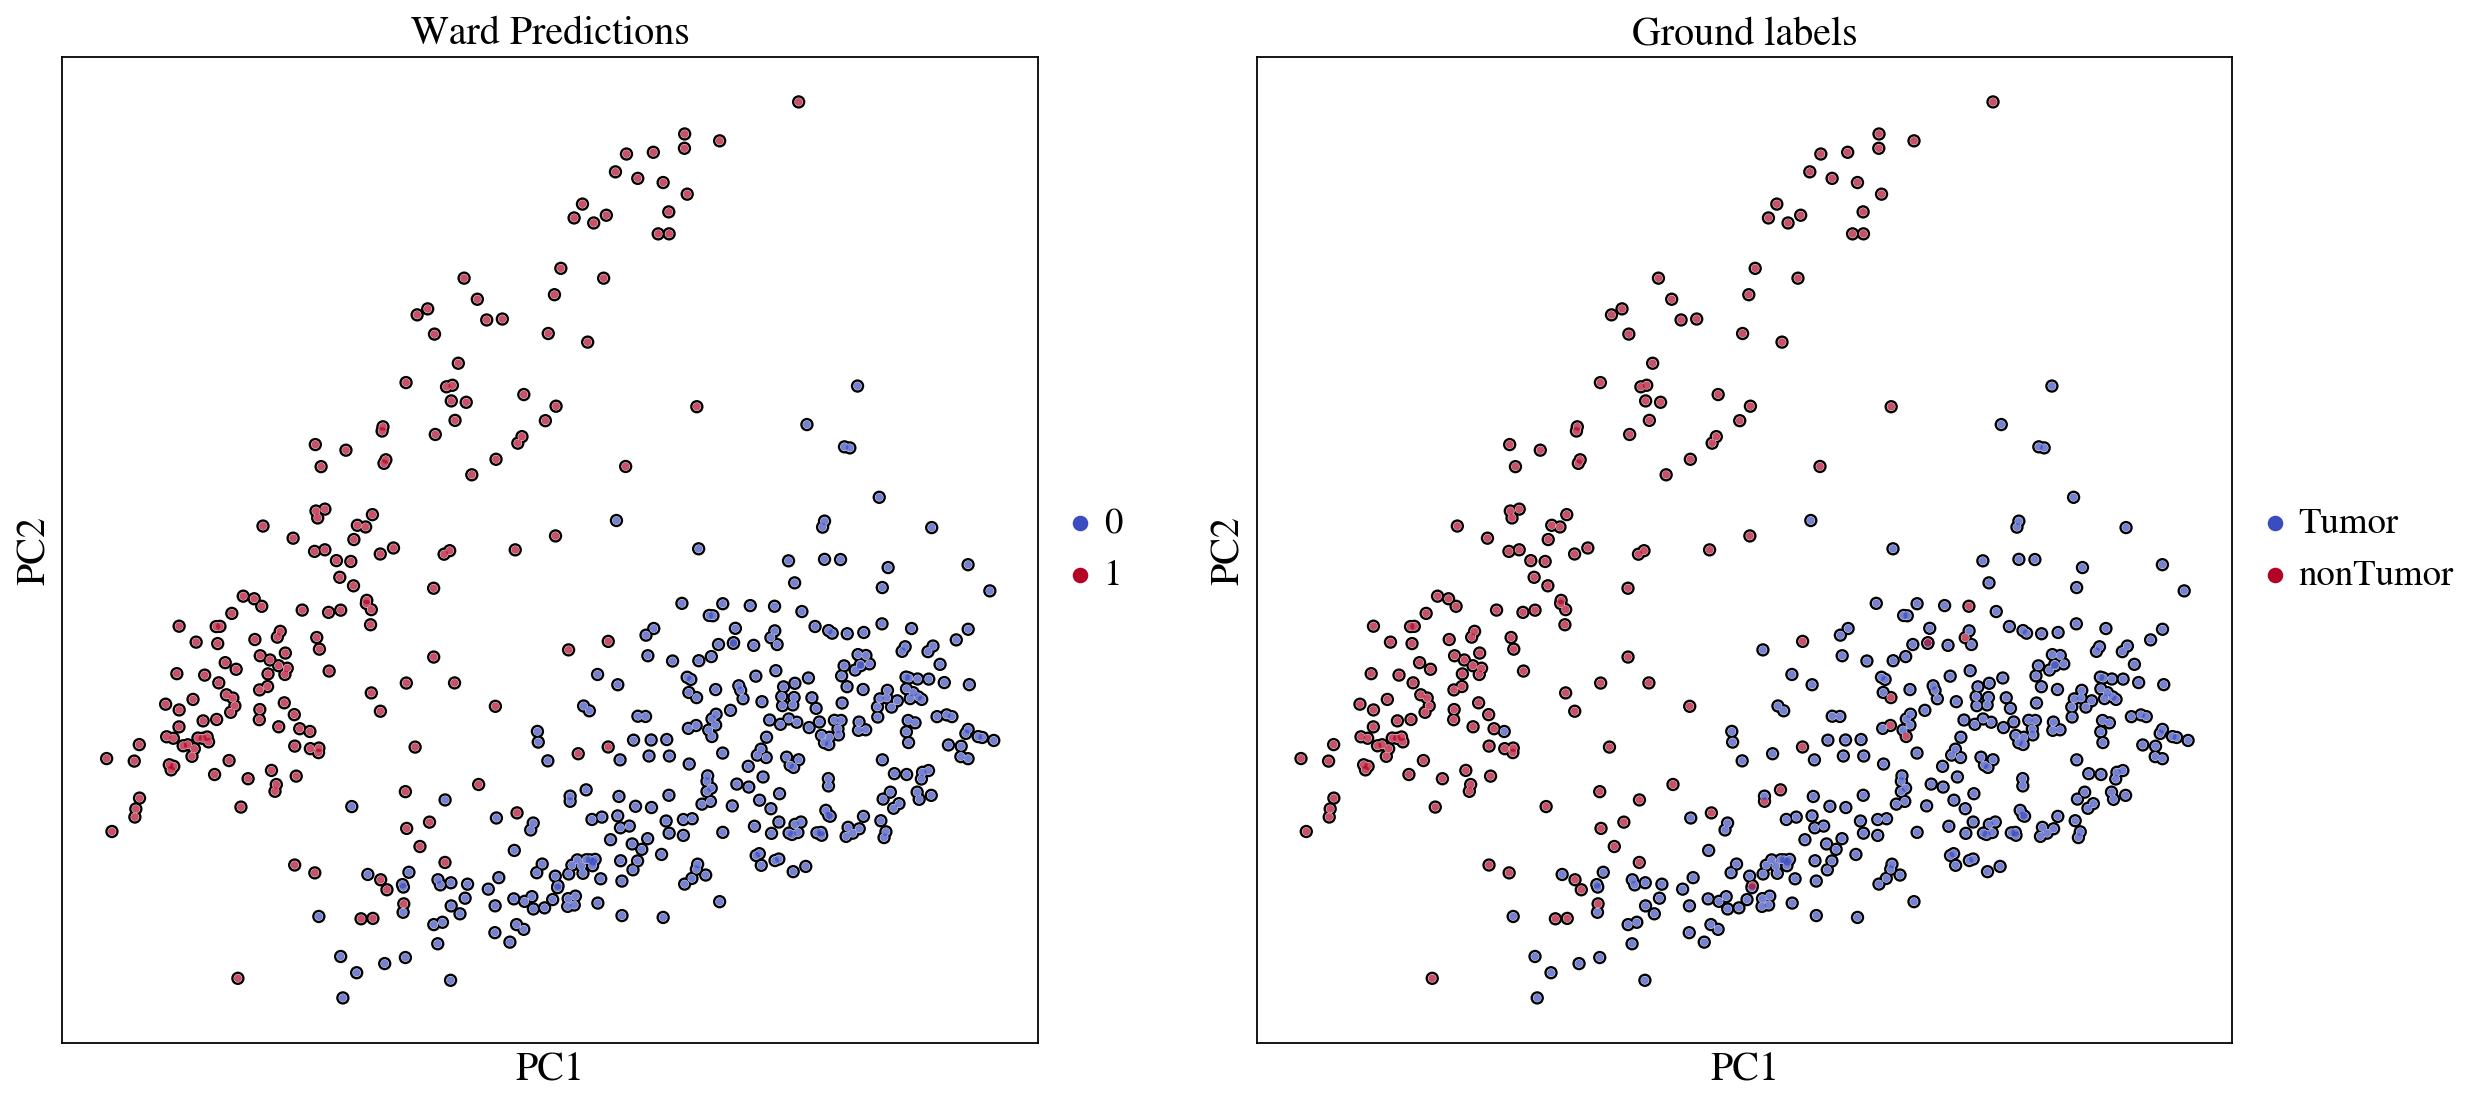

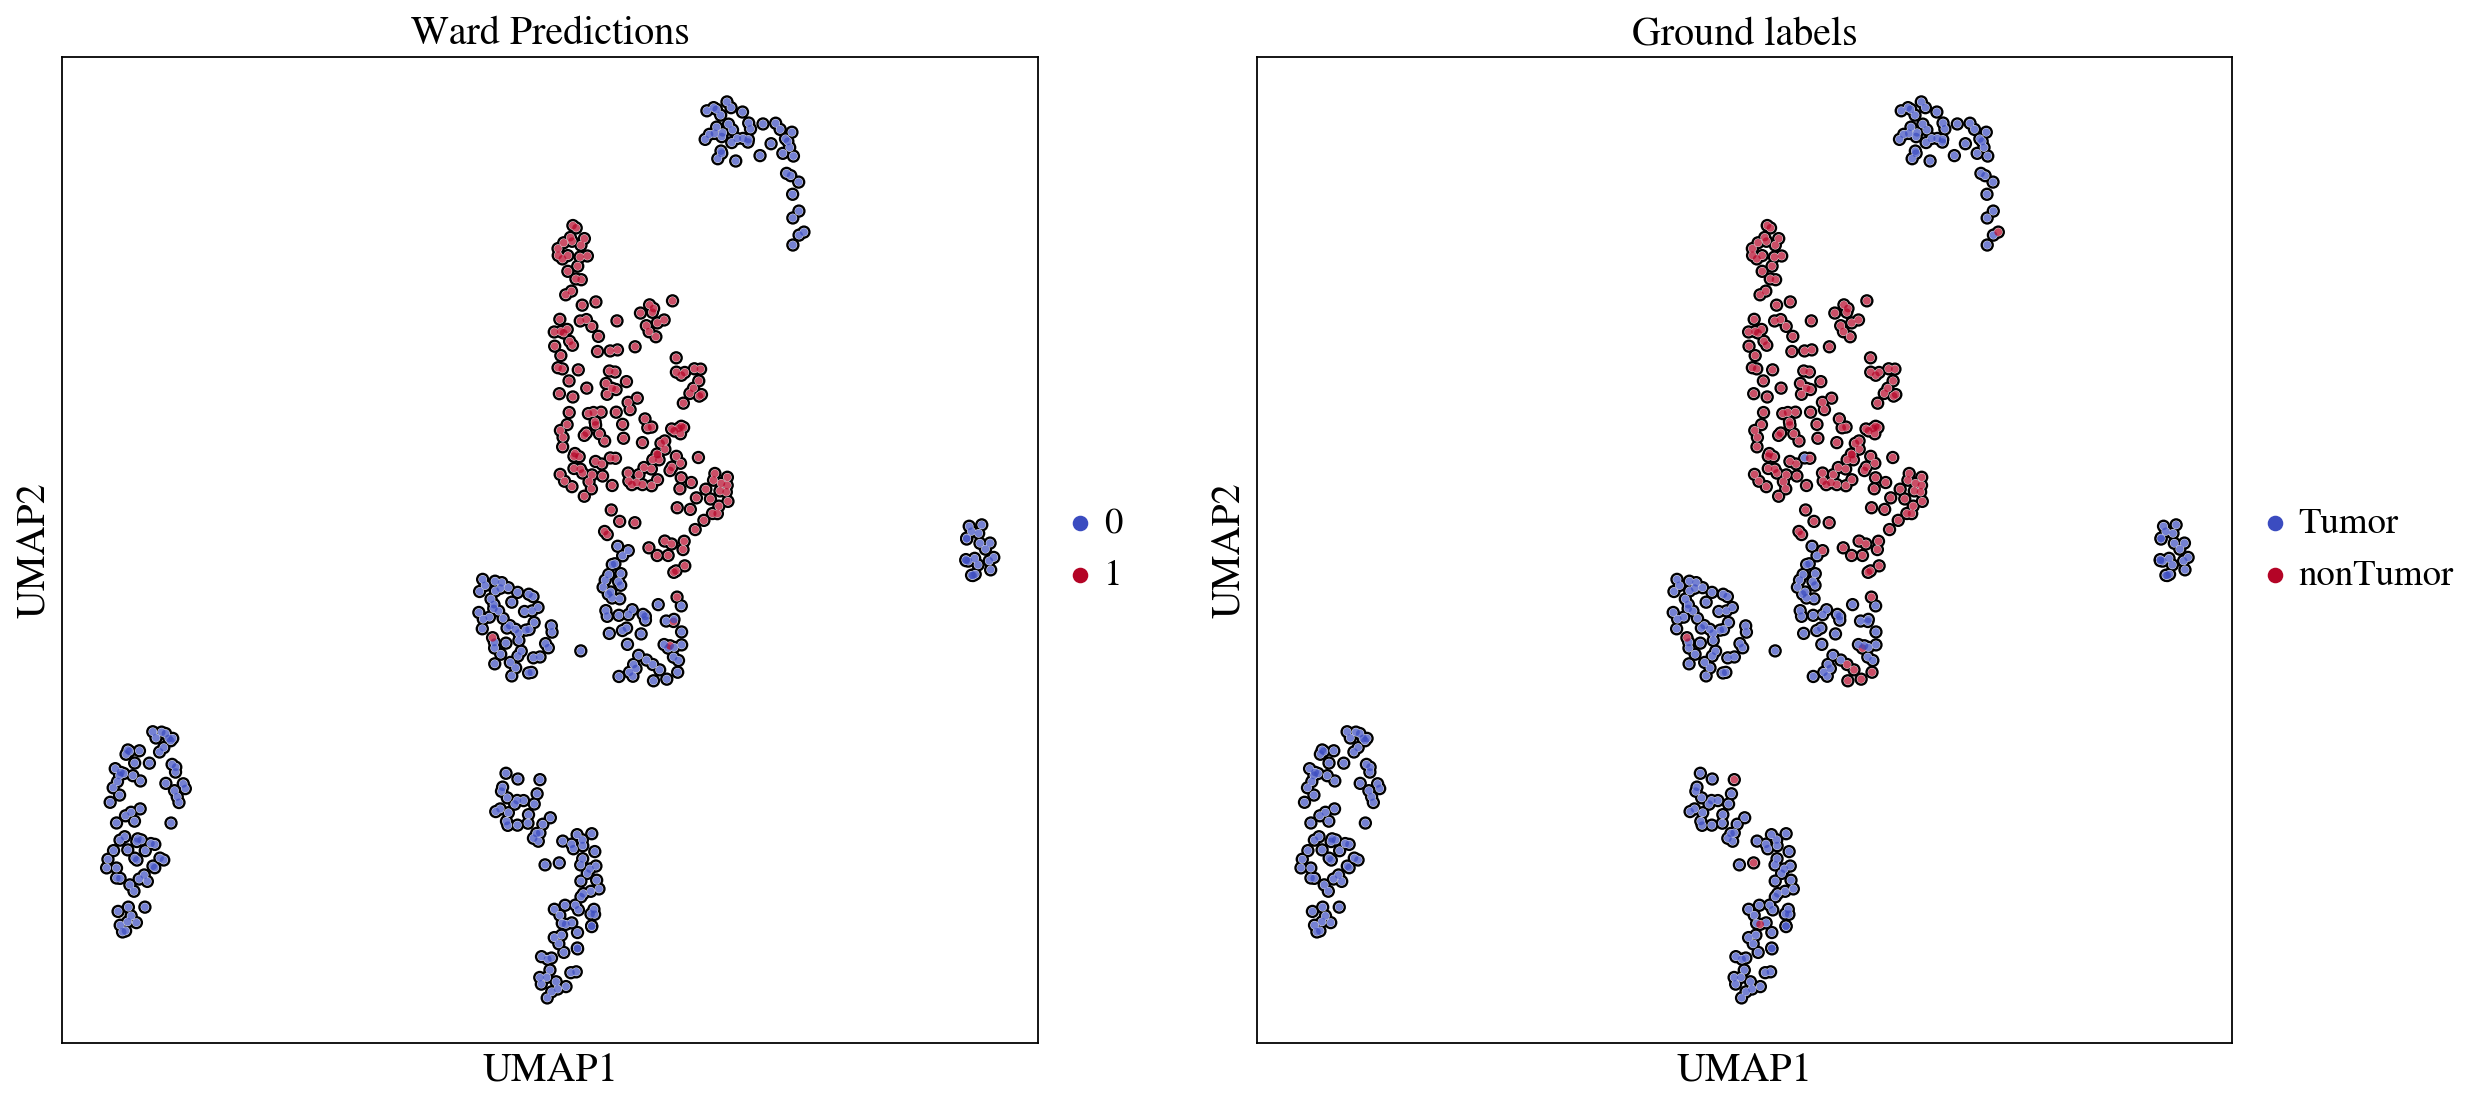

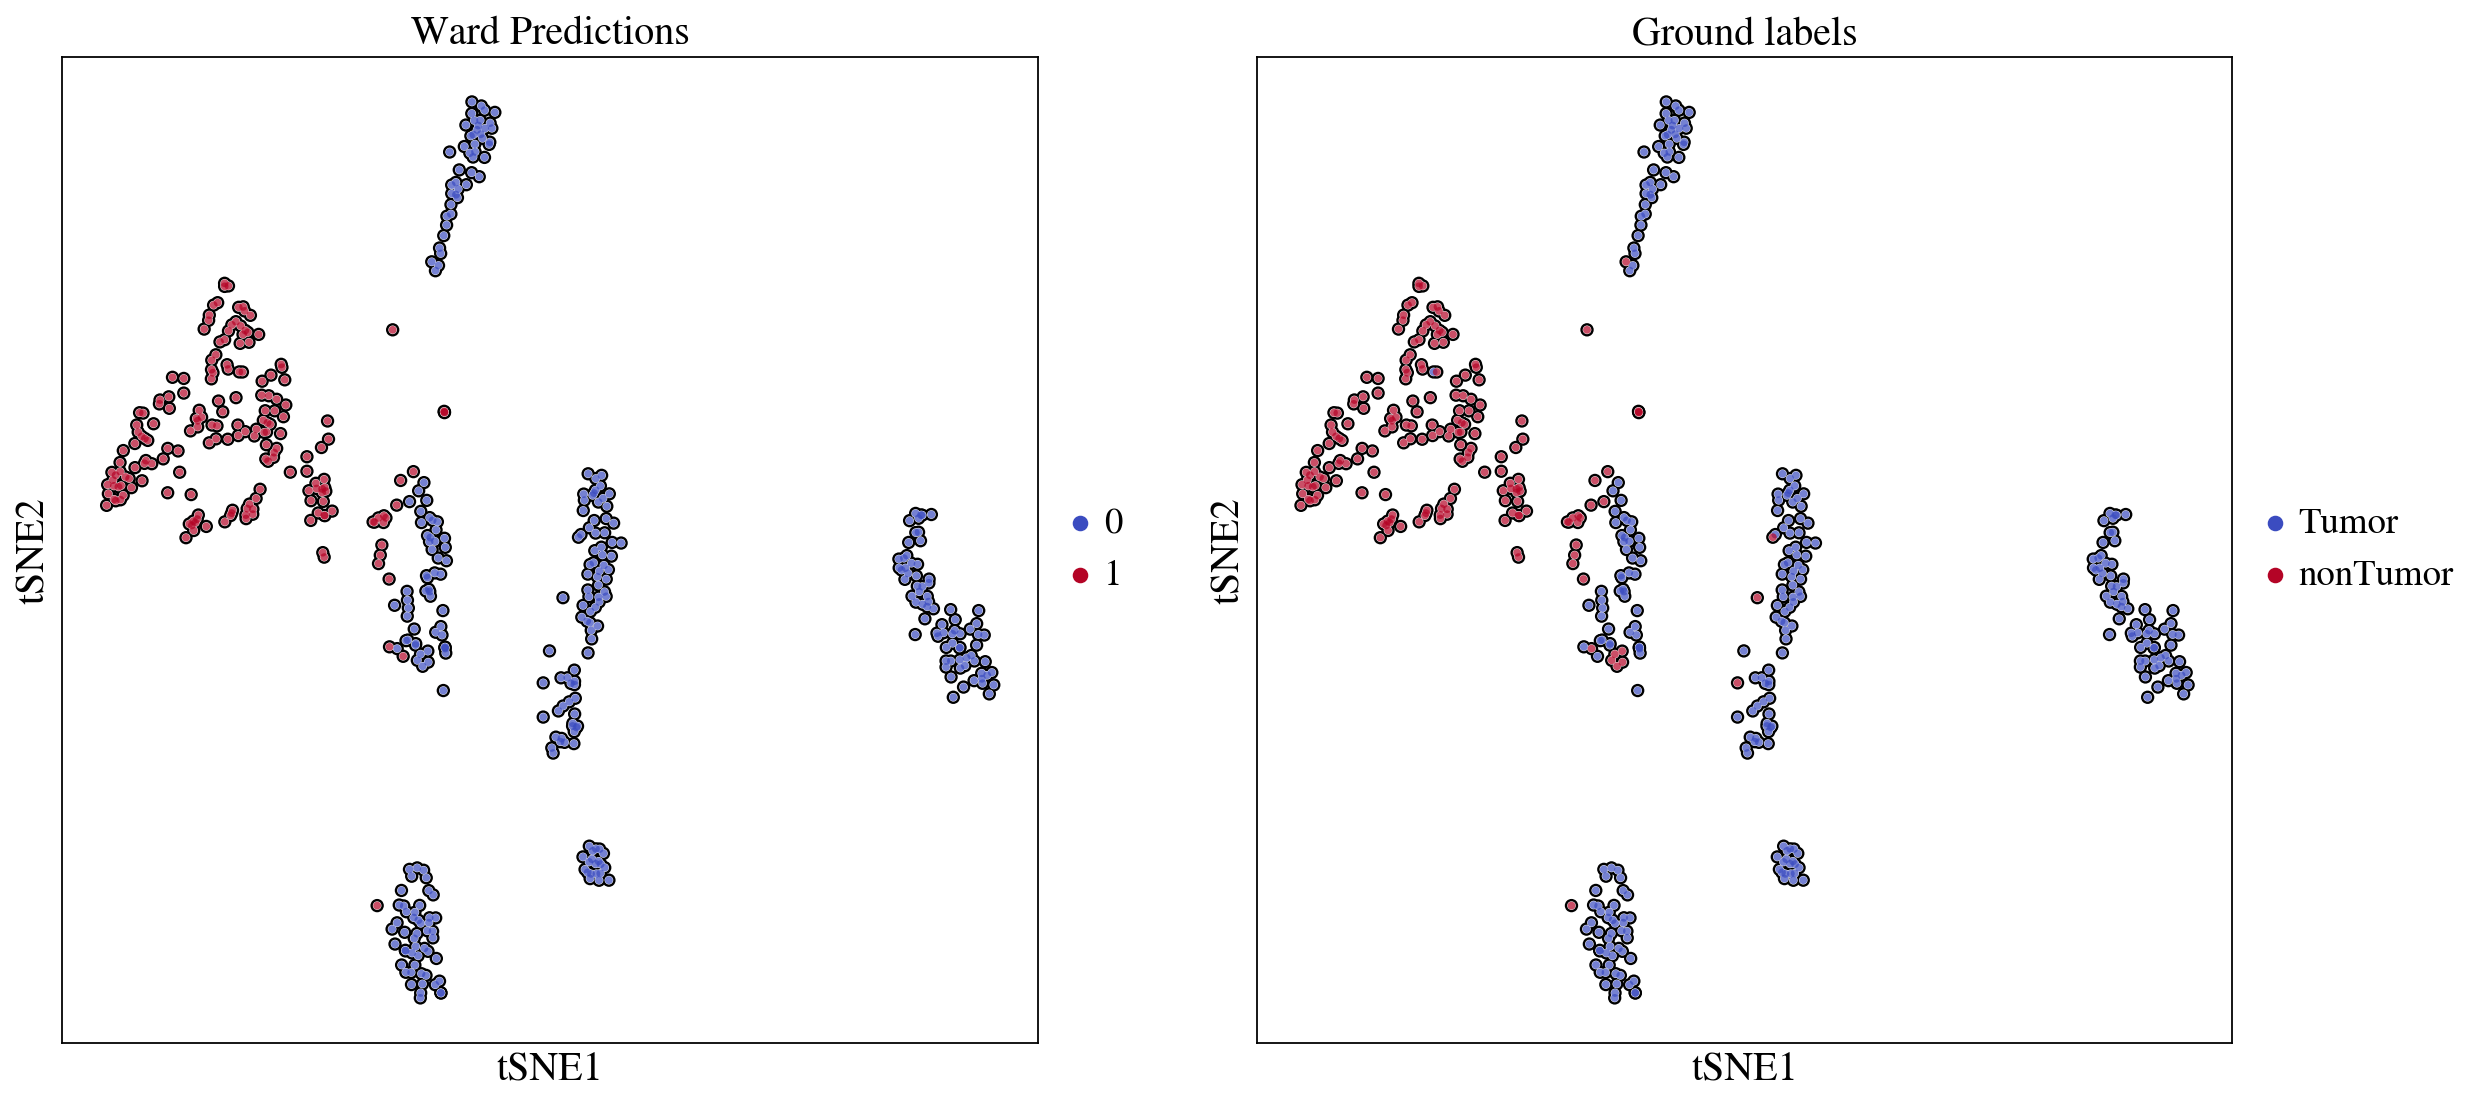

In [13]:

model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = model.fit_predict(data)
hw_score = silhouette_score(data,labels)
hw_ari = adjusted_rand_score(ground_labels, labels)
hw_ami = adjusted_mutual_info_score(ground_labels, labels)
hw_fow = fowlkes_mallows_score(ground_labels,labels)
print(f"The silhouete score in the optimal PCA space is: {hw_score}")
print(f"The adjusted random index (ARI) score with the original labels is: {hw_ari}")
print(f"The adjusted mutual information (AMI) score with to the original labels is: {hw_ami}")
print(f"The fowlkes mallows score with the original labels is: {hw_fow}")

adata.obs['Ward Predictions'] = labels.astype(str)

sc.pl.pca(adata, color=["Ward Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.umap(adata, color=["Ward Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.tsne(adata, color=["Ward Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")

### **Spectral Clustering**

In [14]:
def Spectral_trial(trial):
  n_neighbors = trial.suggest_int("n_neighbors",2,100)
  spectral = SpectralClustering(n_clusters=2,
                                affinity='nearest_neighbors',
                                n_neighbors=n_neighbors,
                                assign_labels="cluster_qr",
                                random_state=42)
  labels = spectral.fit_predict(data)
  try:
    return silhouette_score(data, labels, random_state=42)
  except ValueError:
  # Return the worst score if it does not converge
    return -1

pruner = optuna.pruners.HyperbandPruner()
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(Spectral_trial, n_trials=100, show_progress_bar=True)

# Get the best parameters and objective value
best_params = study.best_params
best_value = study.best_value
print(best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

{'n_neighbors': 66}


The silhouete score in the optimal PCA space is: 0.14385758340358734
The adjusted random index (ARI) score with the original labels is: 0.7226910235793799
The adjusted mutual information (AMI) score with to the original labels is: 0.6158695436868572
The fowlkes mallows score with the original labels is: 0.867166799445084


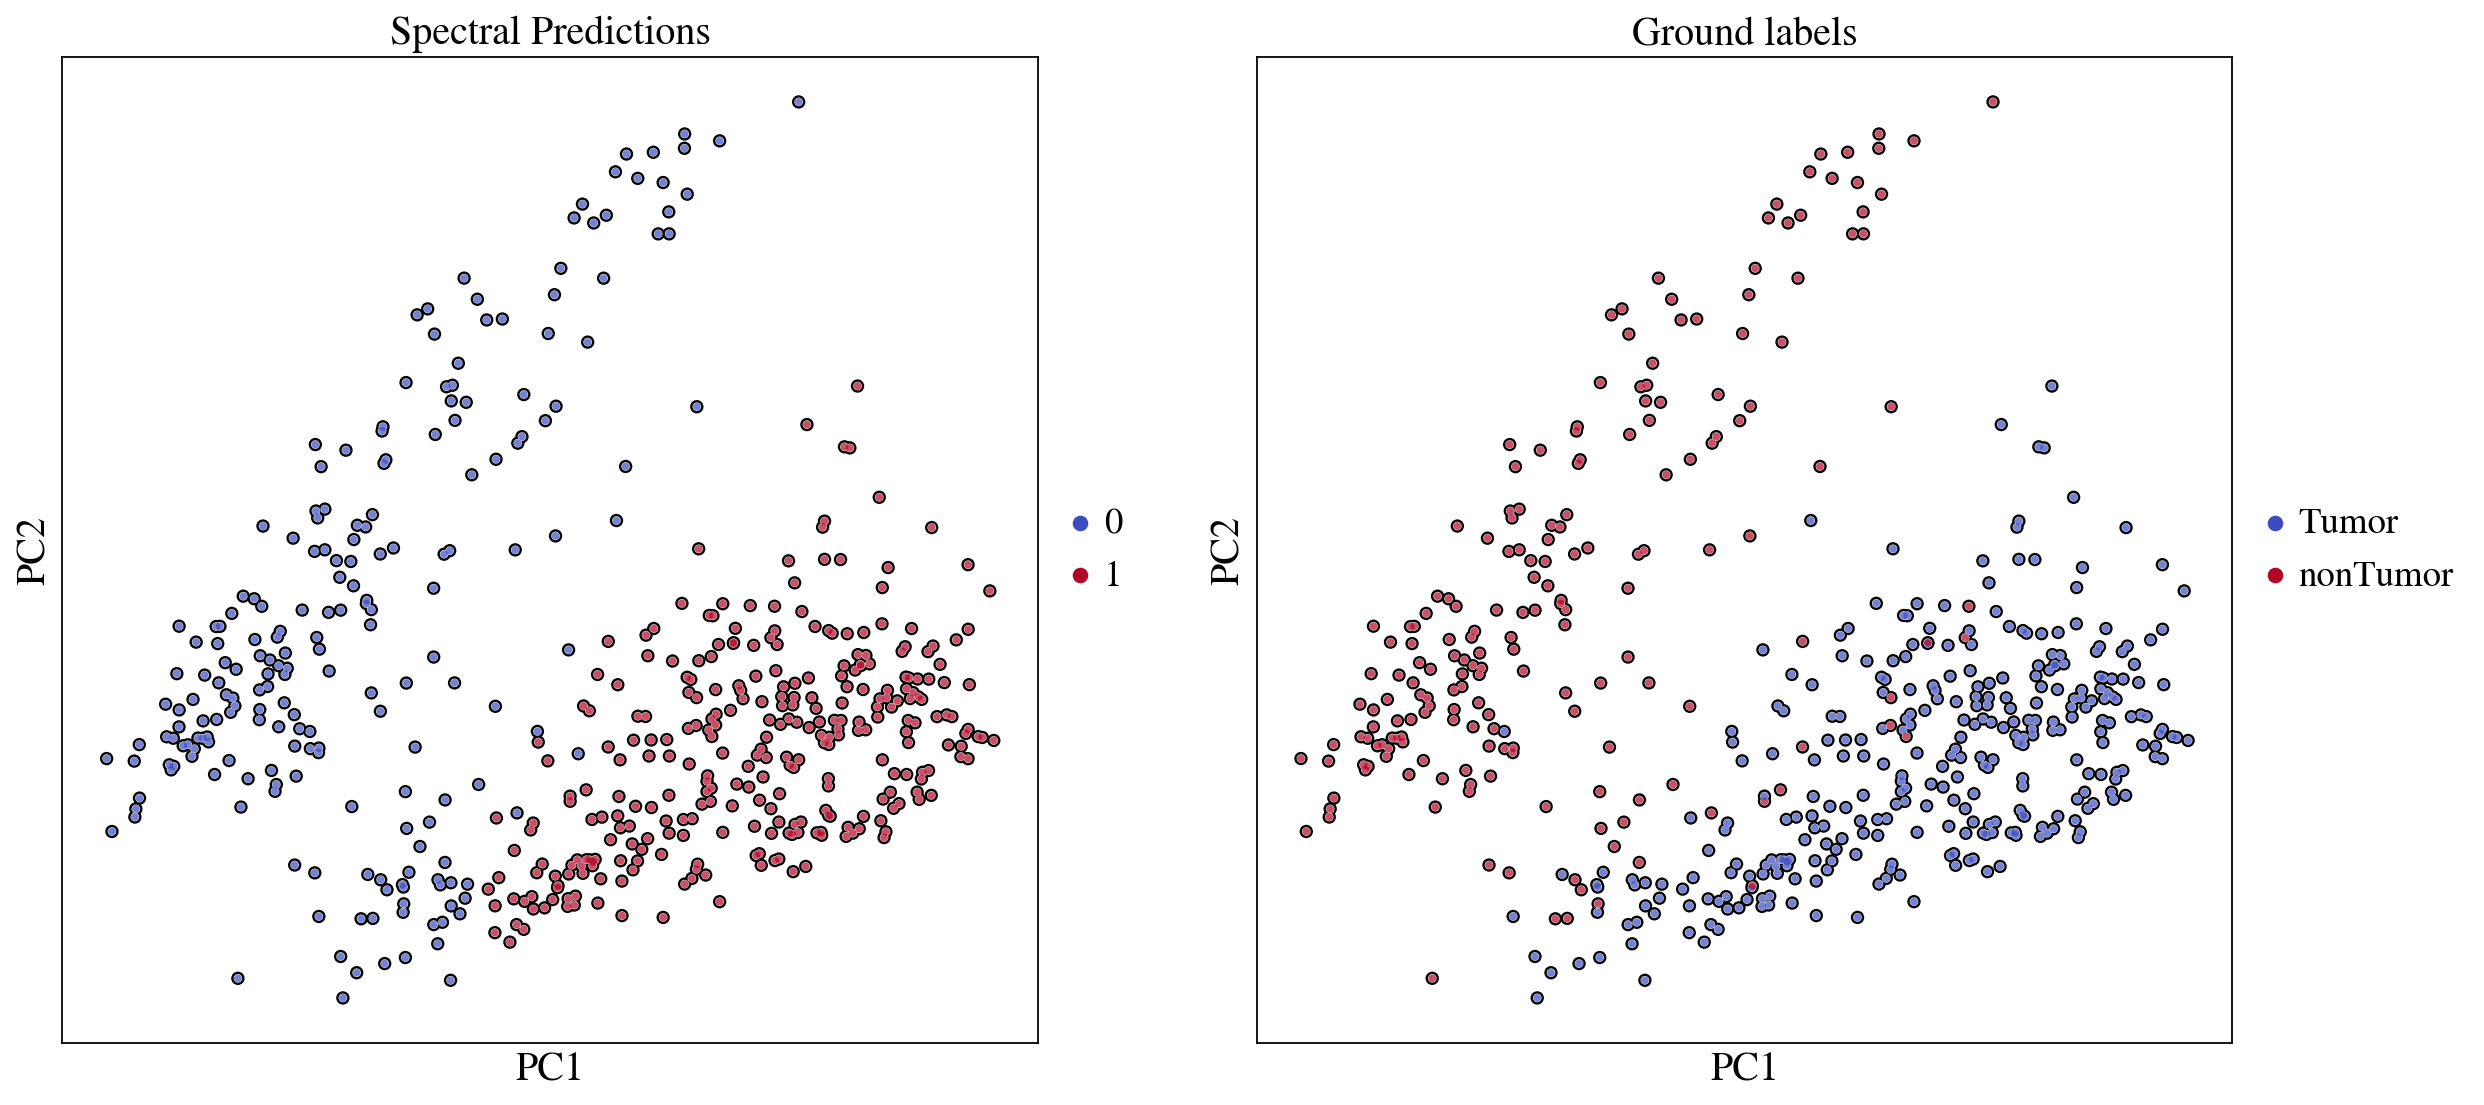

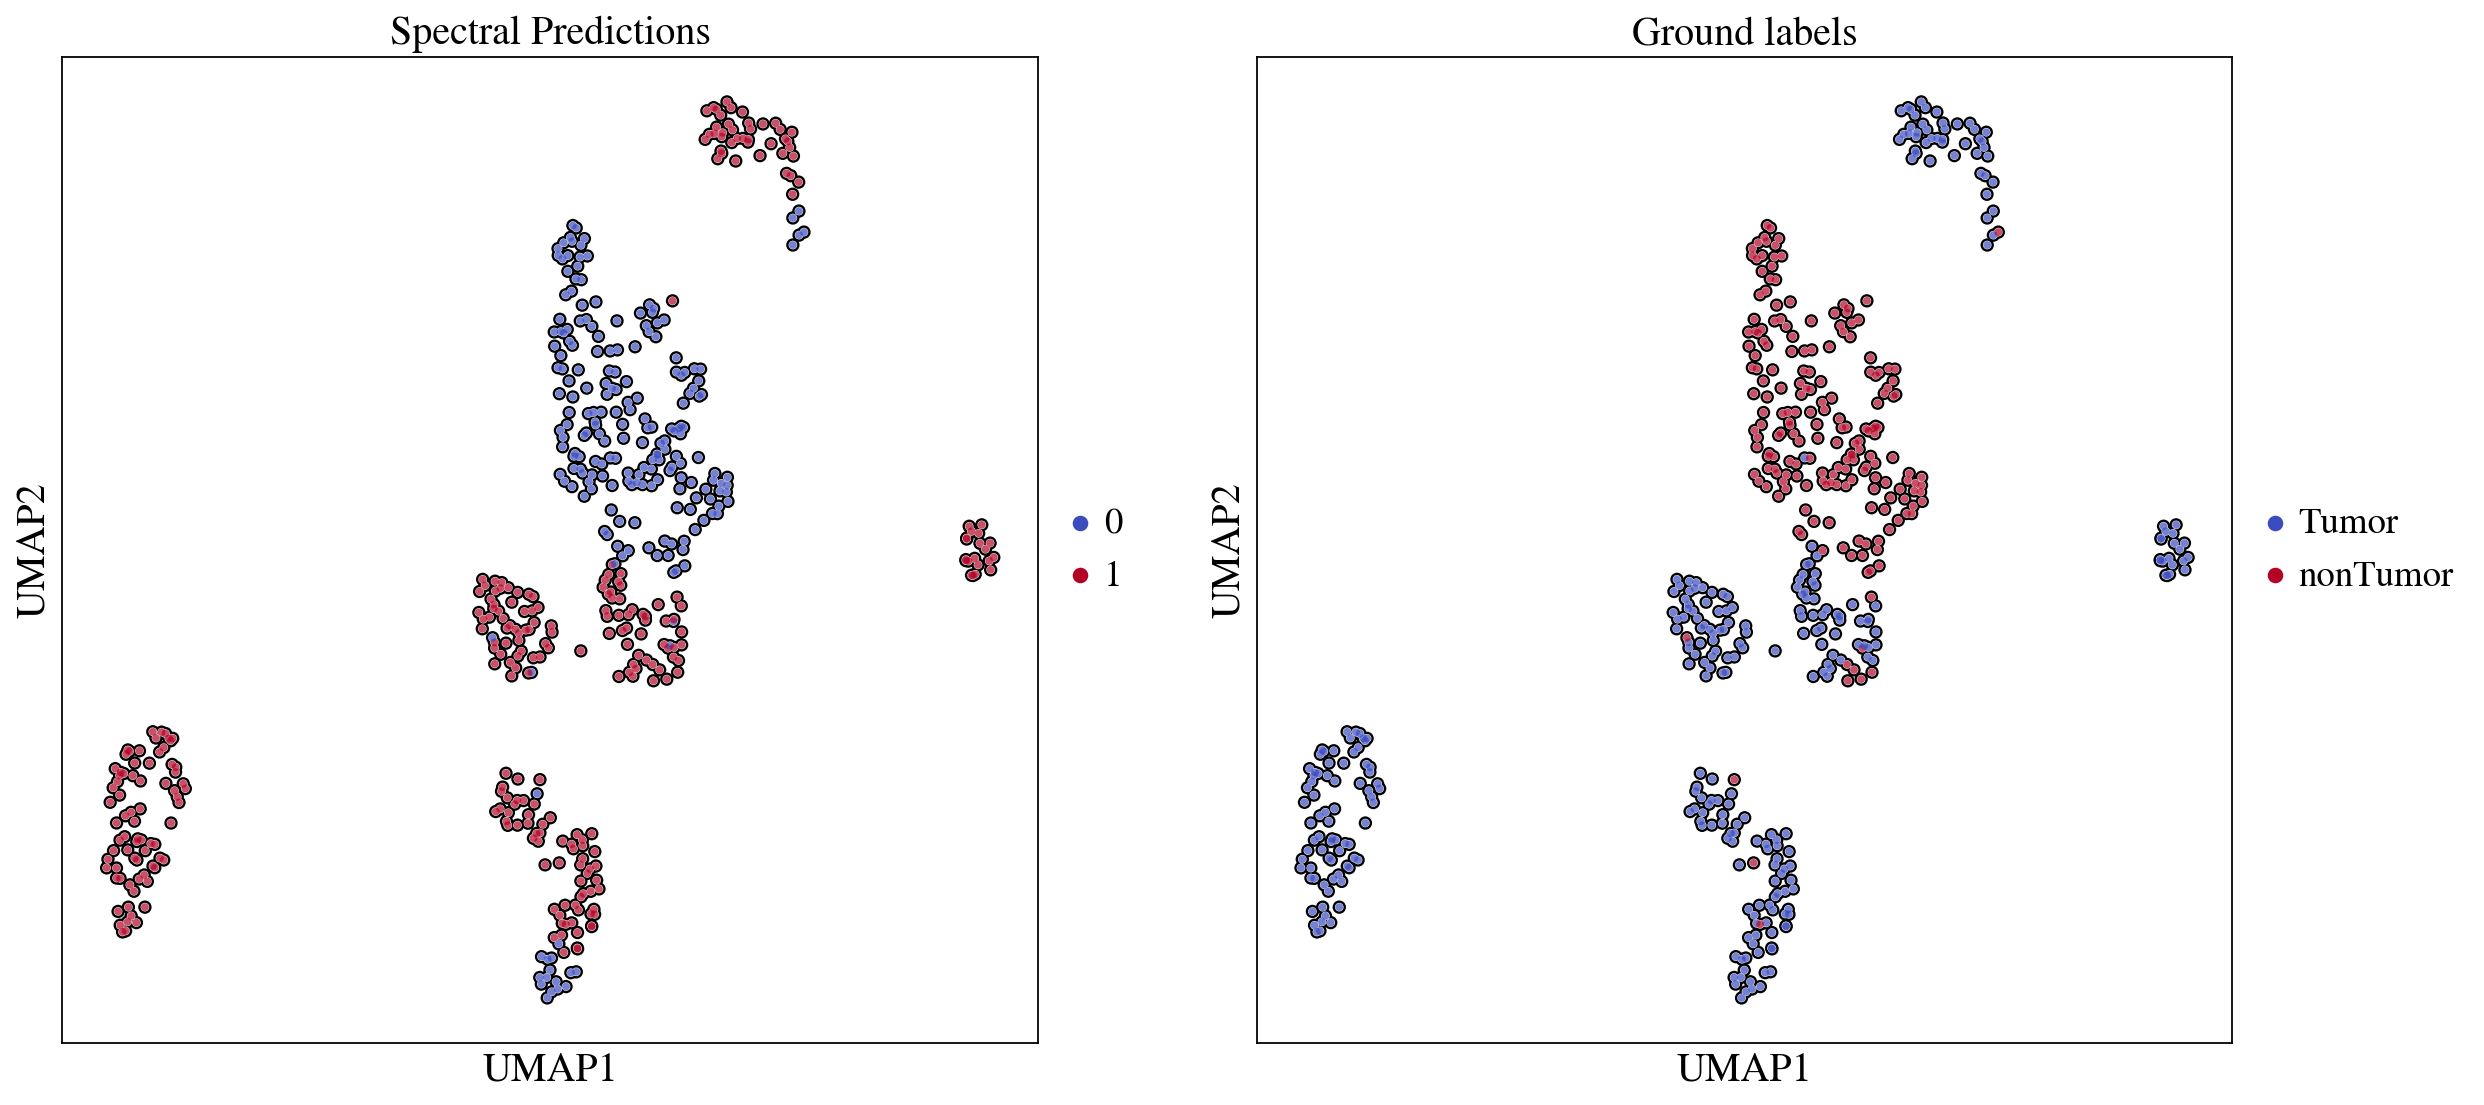

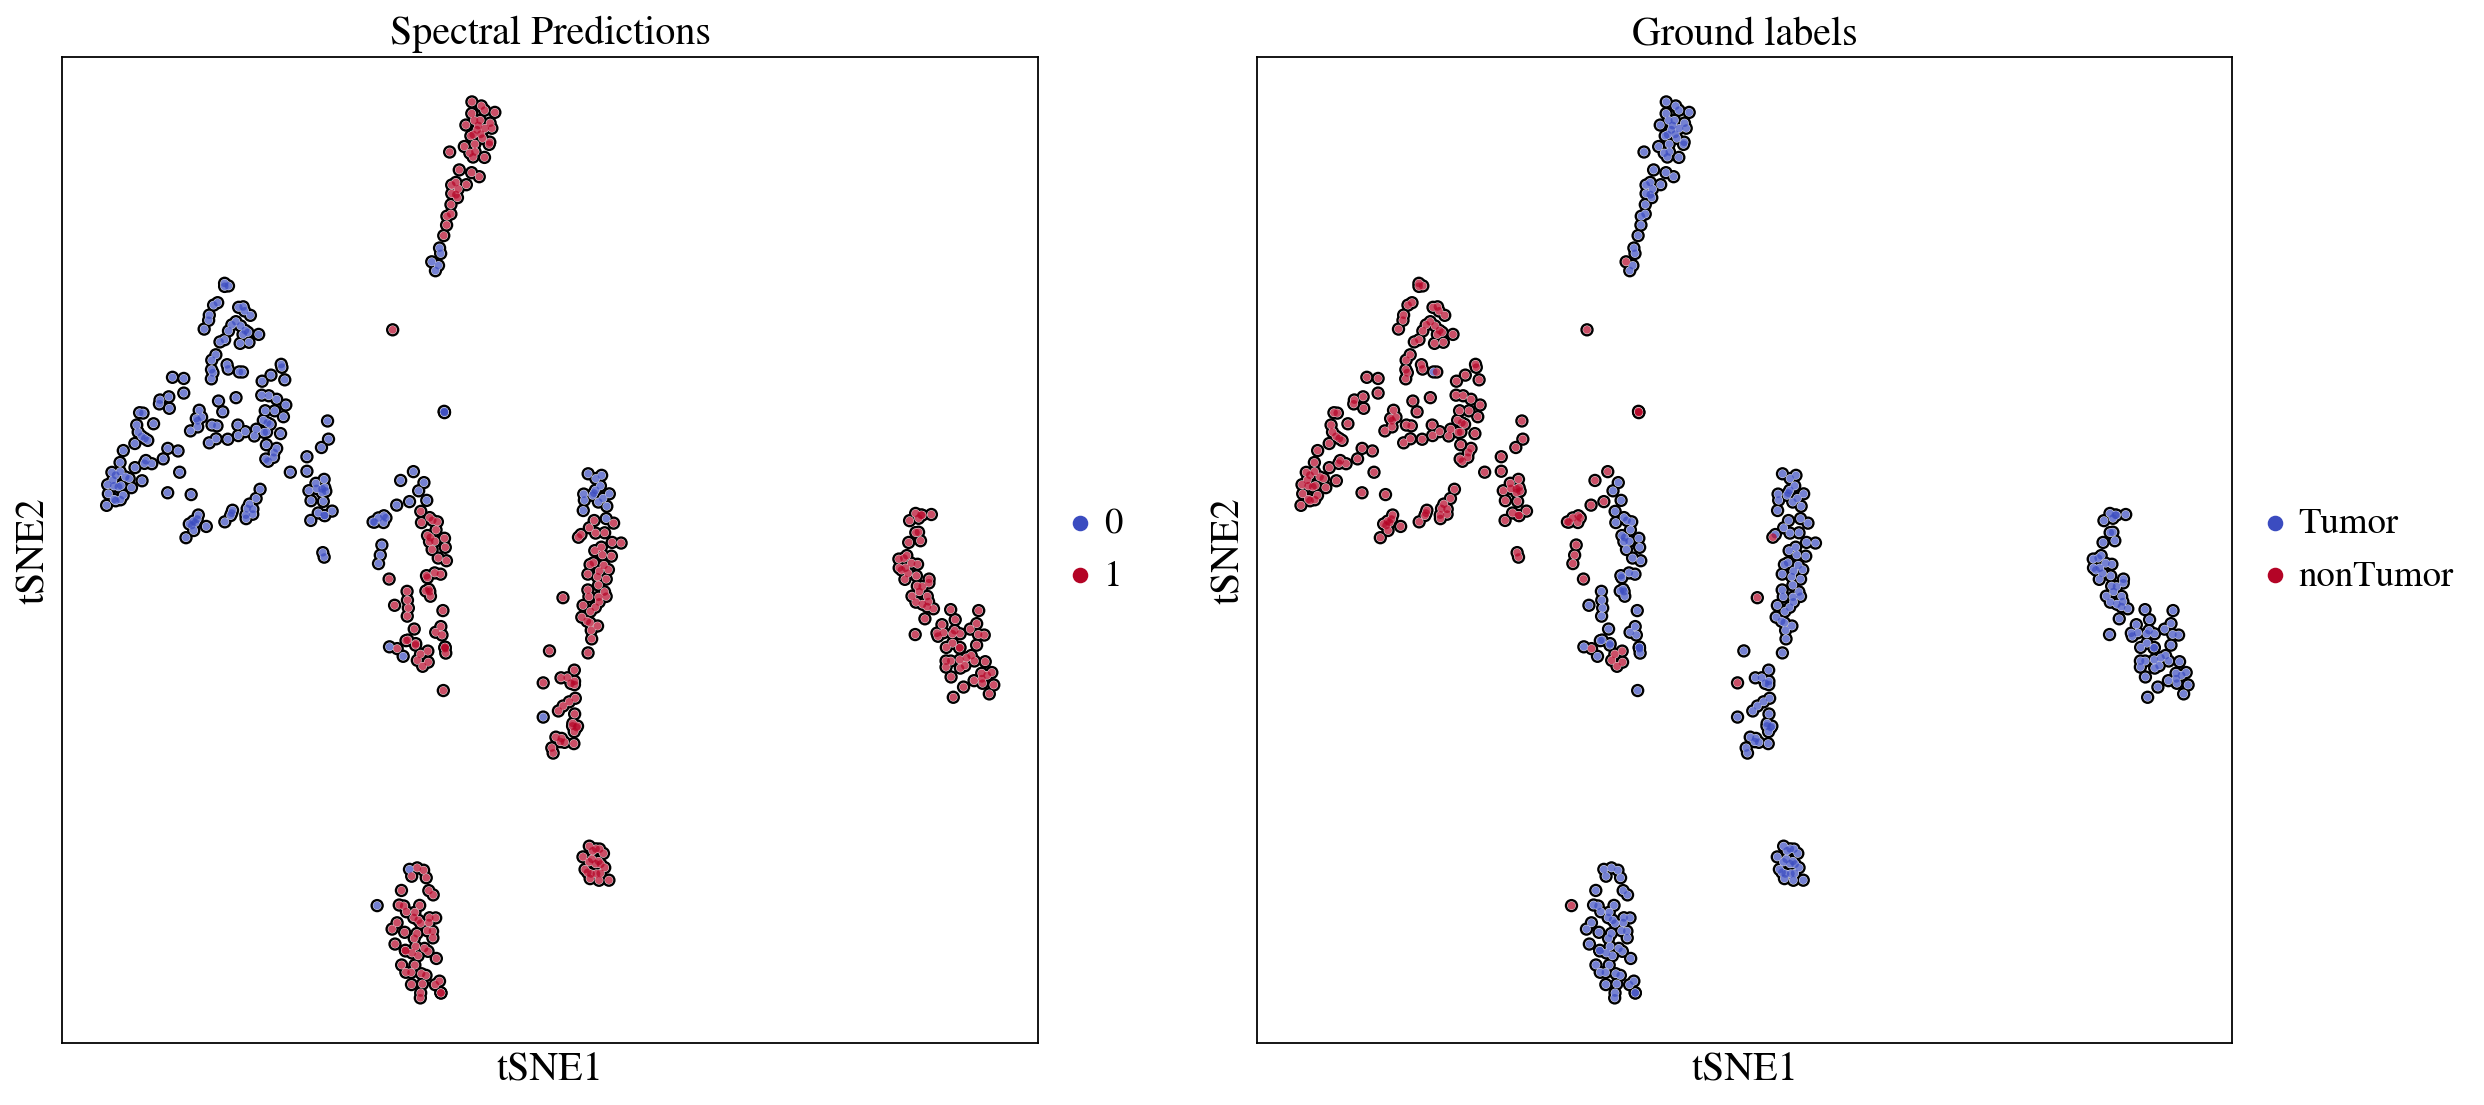

In [15]:
model = SpectralClustering(n_clusters=2,affinity='nearest_neighbors',n_neighbors=best_params['n_neighbors'],assign_labels="cluster_qr",random_state=42)
labels = model.fit_predict(data)
sp_score = silhouette_score(data,labels)
sp_ari = adjusted_rand_score(ground_labels, labels)
sp_ami = adjusted_mutual_info_score(ground_labels, labels)
sp_fow = fowlkes_mallows_score(ground_labels,labels)
print(f"The silhouete score in the optimal PCA space is: {sp_score}")
print(F"The adjusted random index (ARI) score with the original labels is: {sp_ari}")
print(F"The adjusted mutual information (AMI) score with to the original labels is: {sp_ami}")
print(f"The fowlkes mallows score with the original labels is: {sp_fow}")
adata.obs['Spectral Predictions'] = labels.astype(str)

sc.pl.pca(adata, color=["Spectral Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.umap(adata, color=["Spectral Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.tsne(adata, color=["Spectral Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")

### **GMM Clustering**


In [16]:
params, values = optimizeGMM(data,metric = "BIC",max_num_components = 2,show_progress_bar=False,n_trials=150)

The silhouete score in the optimal PCA space is: 0.14385758340358734
The adjusted random index (ARI) score with the original labels is: 0.7226910235793799
The adjusted mutual information (AMI) score with to the original labels is: 0.6158695436868572
The fowlkes mallows score with the original labels is: 0.5148668055681498


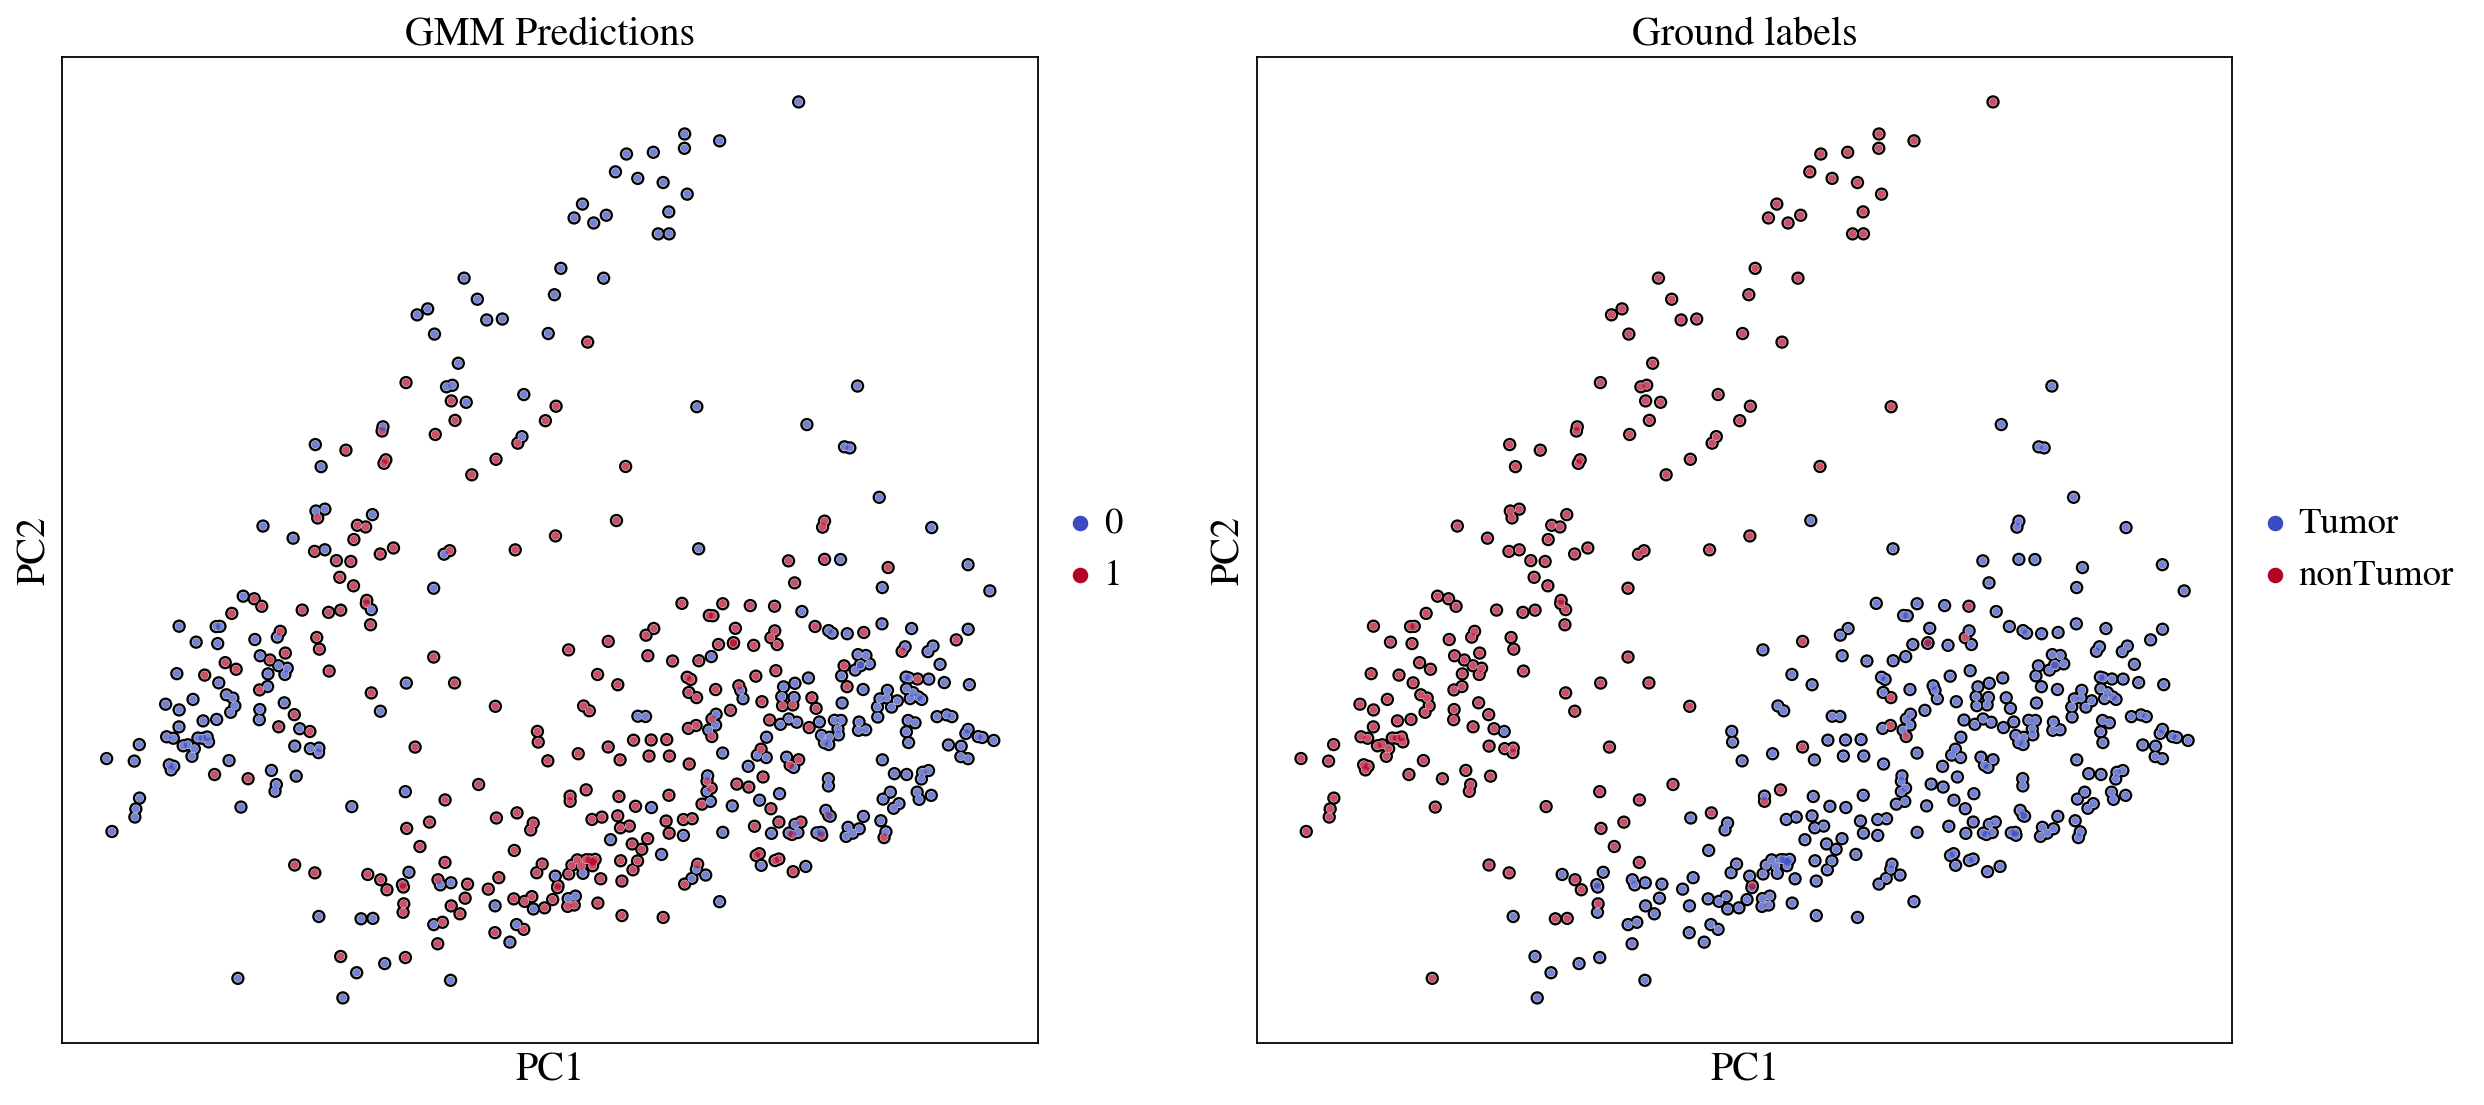

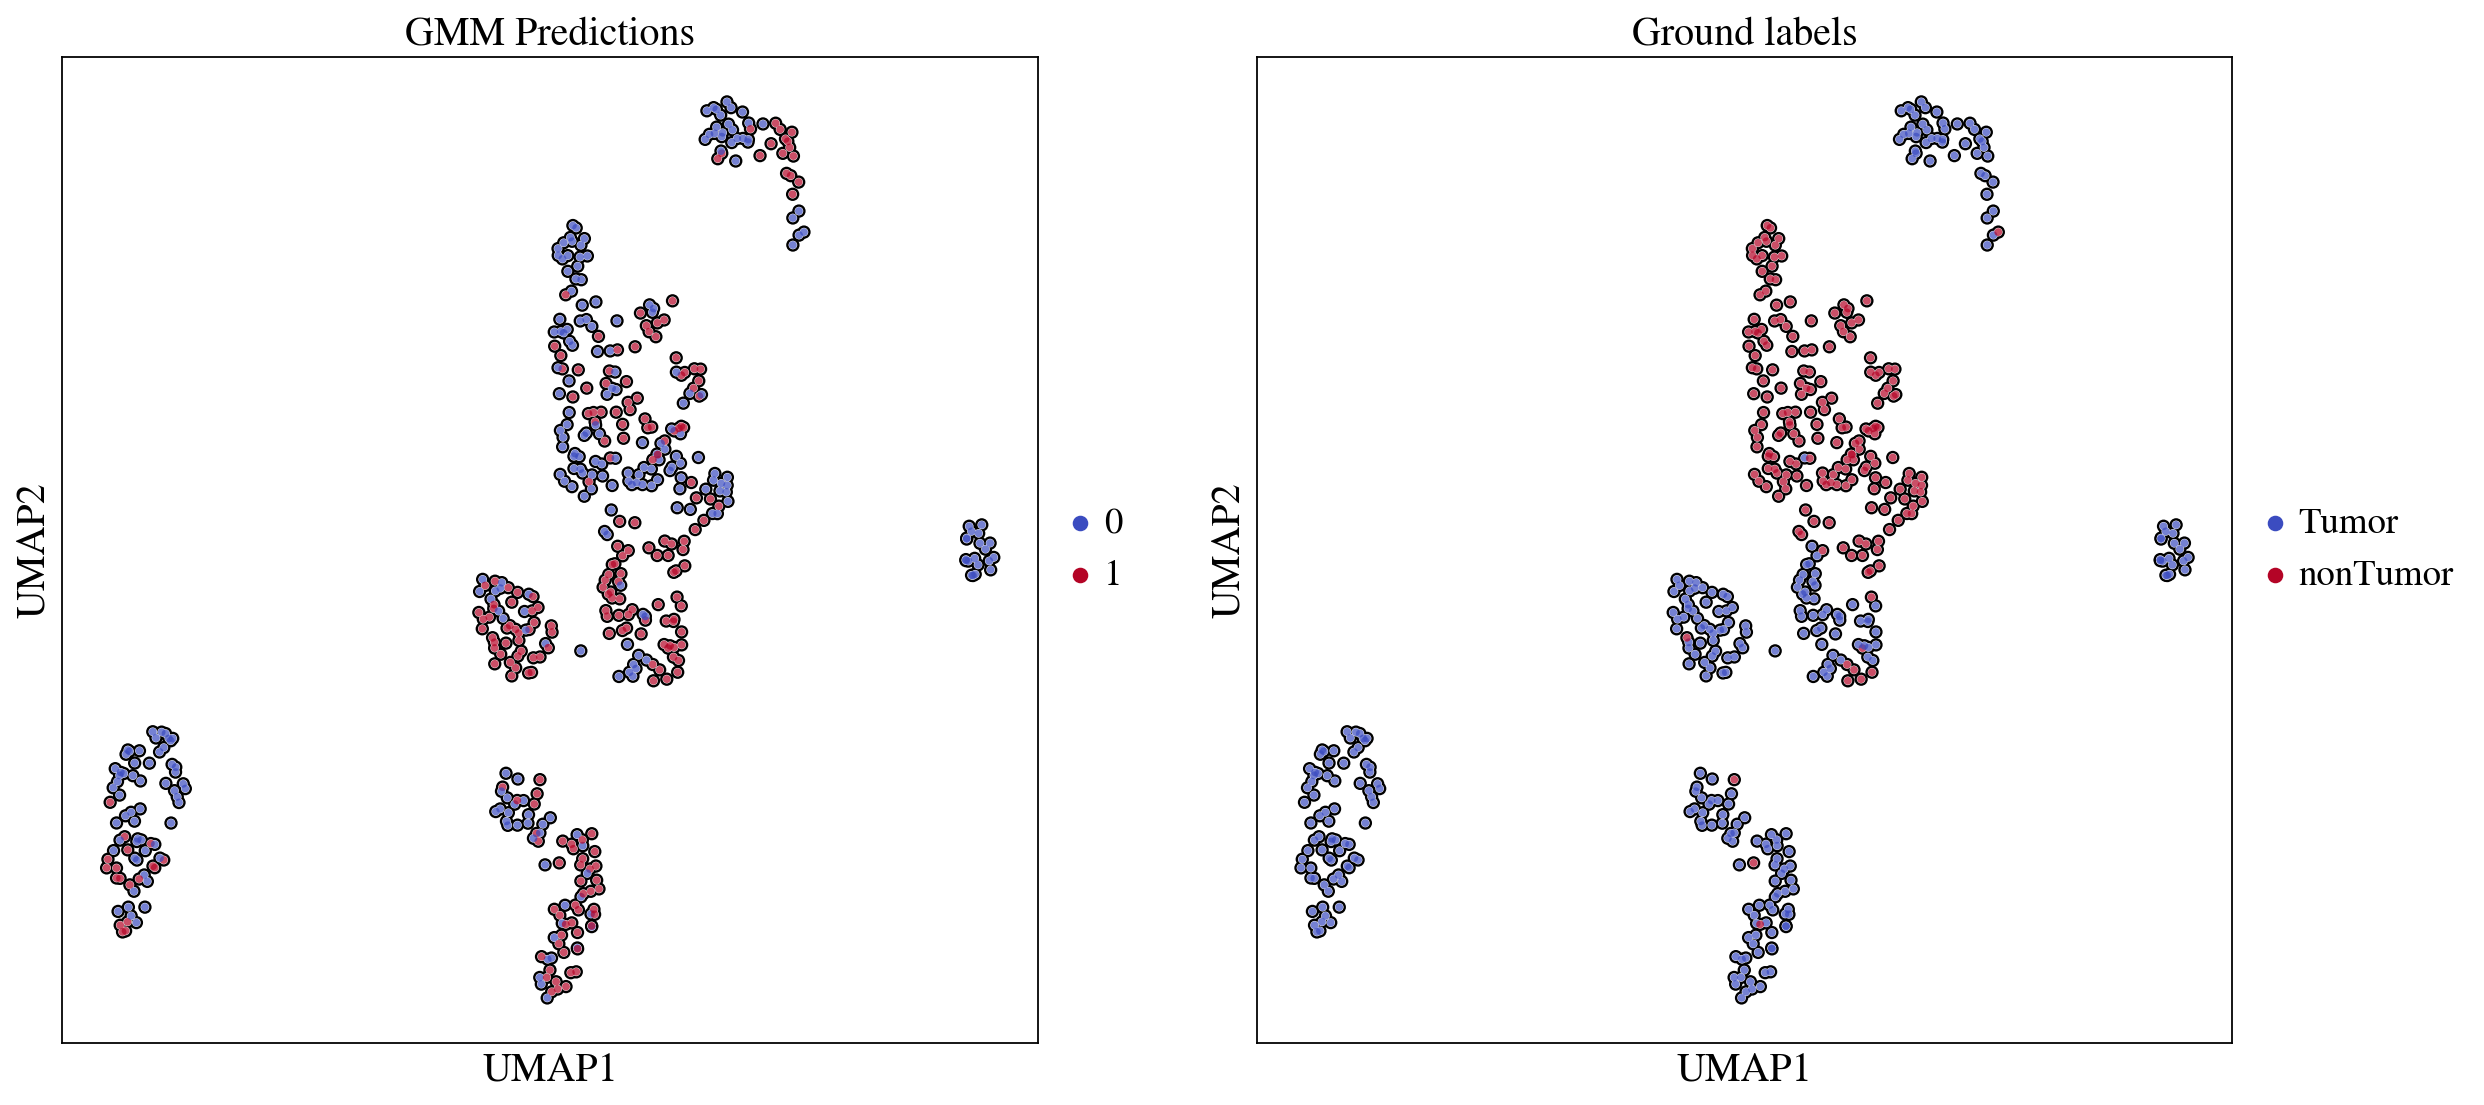

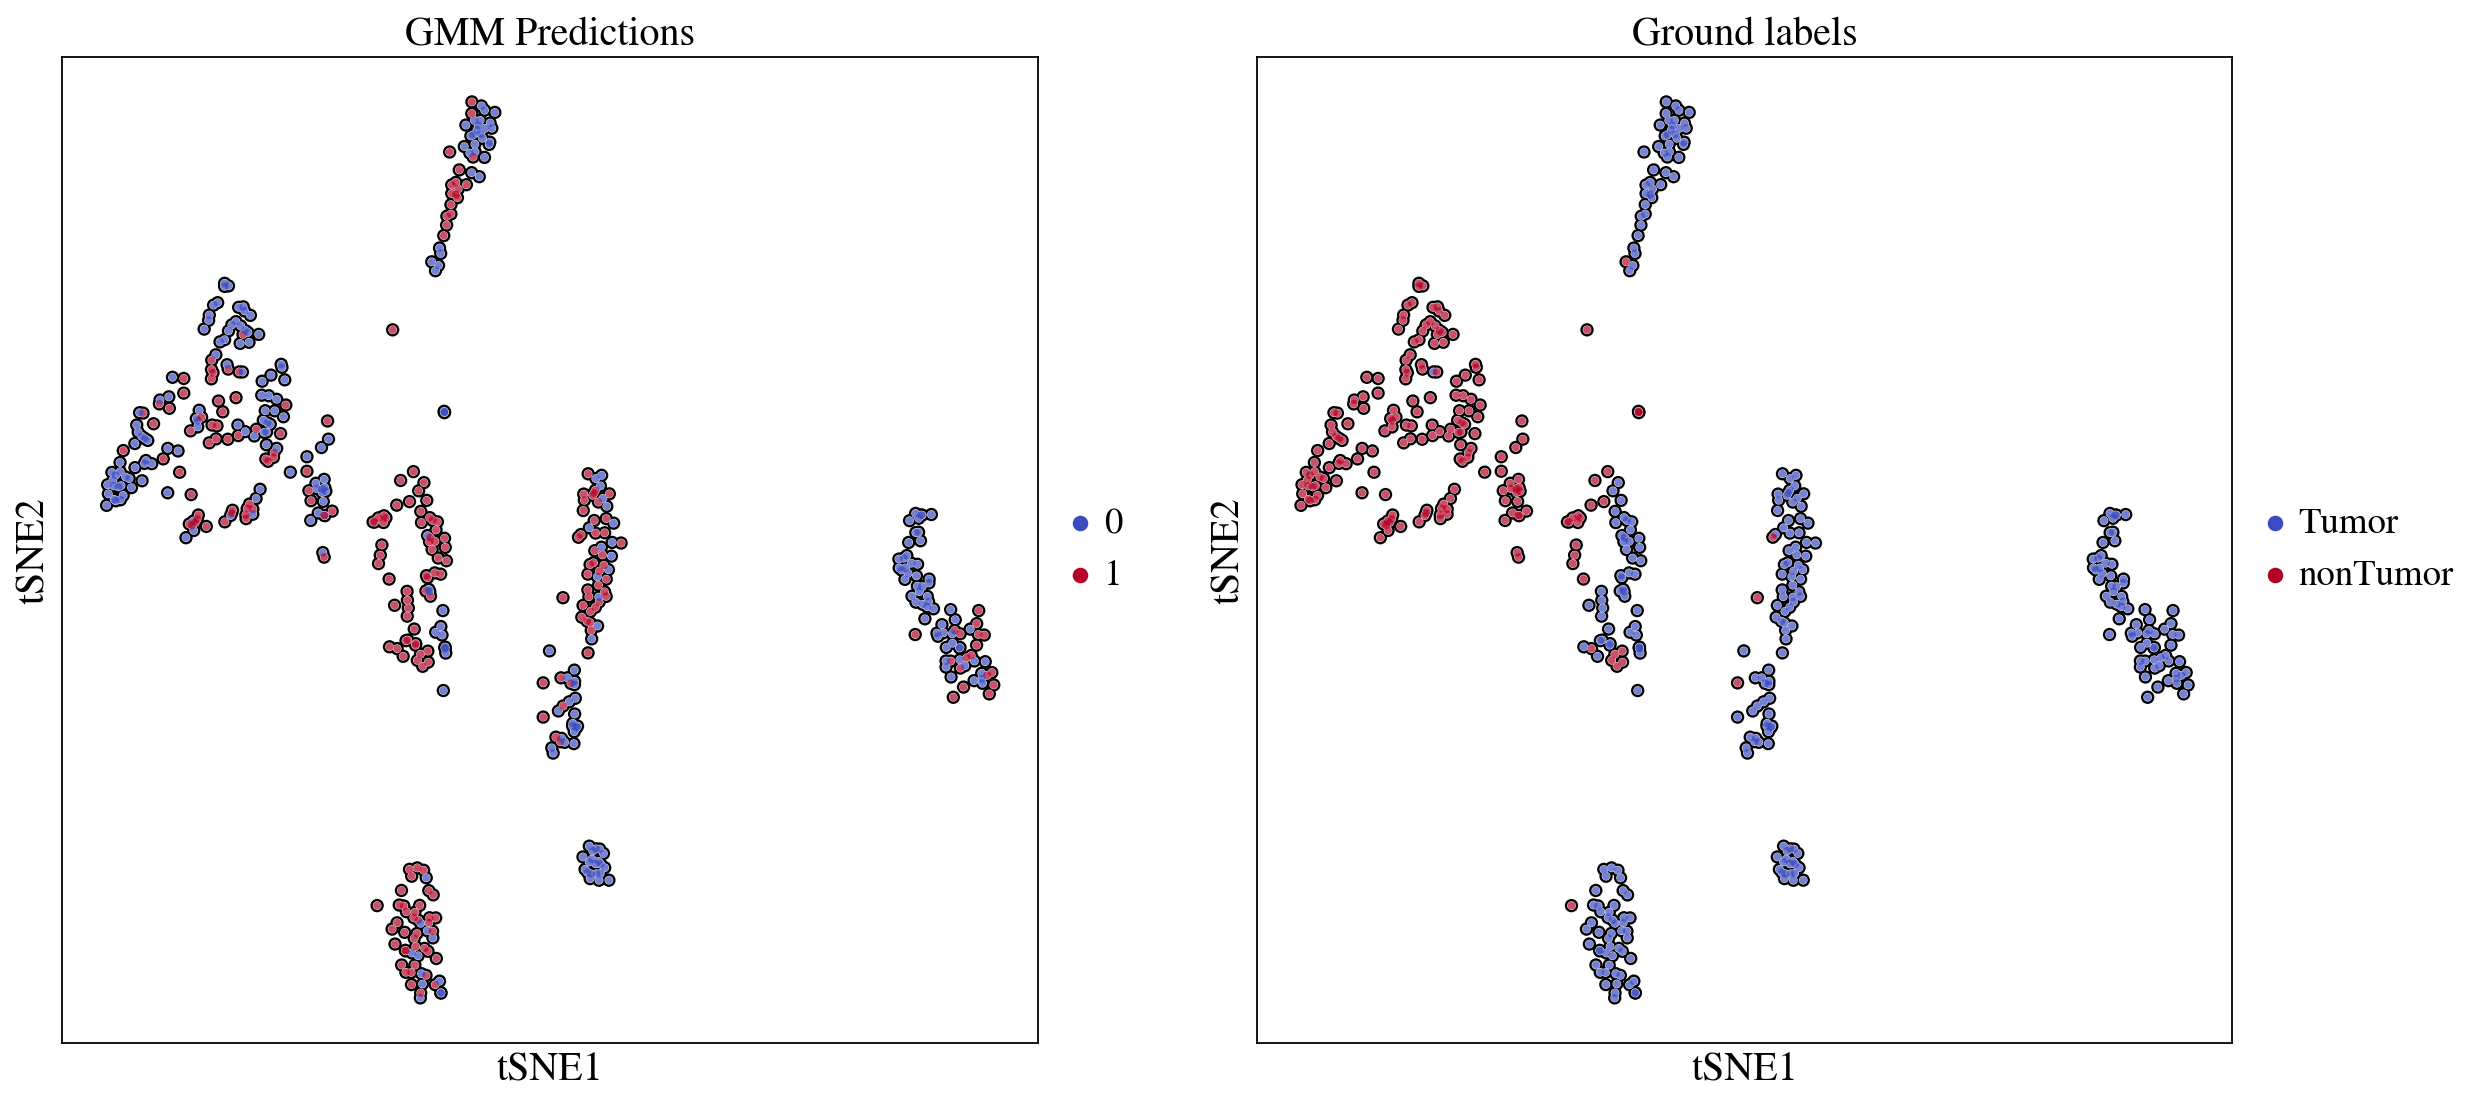

In [17]:
model = GaussianMixture(covariance_type=params[1]['covariance_type'],random_state = params[1]['random_state'],init_params=params[1]['init_params'],n_components=2)
labels = model.fit_predict(data)
gm_score = silhouette_score(data,labels)
gm_ari = adjusted_rand_score(ground_labels, labels)
gm_ami = adjusted_mutual_info_score(ground_labels, labels)
gm_fow = fowlkes_mallows_score(ground_labels,labels)
print(f"The silhouete score in the optimal PCA space is: {sp_score}")
print(f"The adjusted random index (ARI) score with the original labels is: {sp_ari}")
print(f"The adjusted mutual information (AMI) score with to the original labels is: {sp_ami}")
print(f"The fowlkes mallows score with the original labels is: {gm_fow}")
adata.obs['GMM Predictions'] = labels.astype(str)

sc.pl.pca(adata, color=["GMM Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.umap(adata, color=["GMM Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.tsne(adata, color=["GMM Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")

## Results

In [18]:
results_df = pd.DataFrame({"ARI (with original)": [0,hw_ari,ha_ari, sp_ari, gm_ari],
                          "AMI (with original)": [0,hw_ami,ha_ari, sp_ami, gm_ami],
                          "FMI (with original)":[0,hw_fow,ha_fow,sp_fow,gm_fow],
                          "silhouette": [score,hw_score,ha_score,sp_score, gm_score]})
results_df.index = ['Original Clustering','Ward Linkage','Average Linkage','Spectral',"GMM"]
results_df

ARI (with original)  AMI (with original)  \
Original Clustering             0.000000             0.000000   
Ward Linkage                    0.892380             0.817489   
Average Linkage                 0.002450             0.002450   
Spectral                        0.722691             0.615870   
GMM                            -0.000243             0.002016   

                     FMI (with original)  silhouette  
Original Clustering             0.000000    0.134850  
Ward Linkage                    0.949584    0.139335  
Average Linkage                 0.725544    0.233887  
Spectral                        0.867167    0.143858  
GMM                             0.514867    0.025818

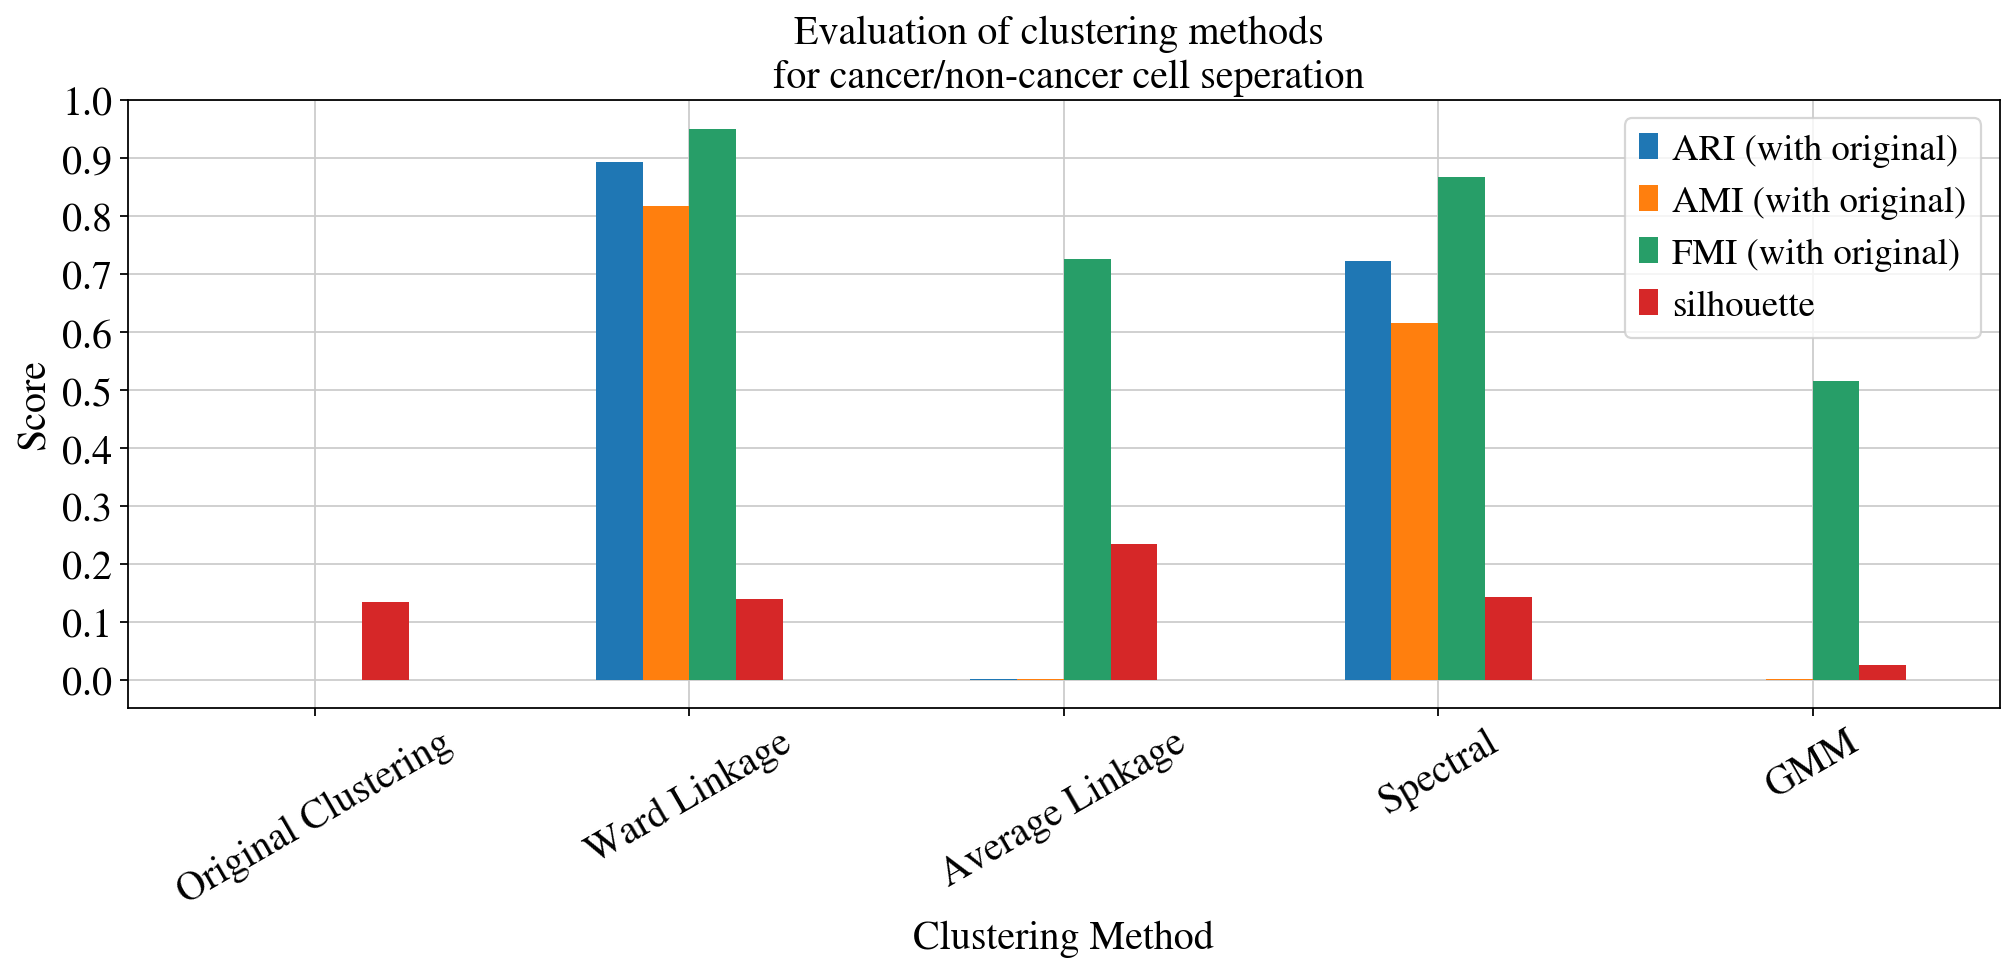

In [19]:
results_df.plot(kind='bar', rot=30,figsize=(15,5))
plt.title("Evaluation of clustering methods \n for cancer/non-cancer cell seperation")
plt.ylabel("Score")
plt.xlabel("Clustering Method")
plt.yticks(np.arange(0.0,1.1,0.1))
plt.show()

Its clear that ward linkage has the advantage over the other clustering methods, so it will be the method of choice.

# **Immune and Stromal cell seperation**

## *Estimate algorithm results*

To assign tumour purity, immunal and stromal scores to the cells, we followed the researchers' approach and used the `ESTIMATE` are package as seen in `Estimate.r`. Thus assigns scores for each category to all cells.

In [20]:
estimate_scores = pd.read_csv("datasets/estimate_score.gct", delimiter="\t", header=2)
estimate_scores = estimate_scores.T.iloc[2:, :]
estimate_scores = estimate_scores.rename(columns={0: 'StromalScore', 1: 'ImmuneScore', 2: 'ESTIMATEScore', 3: 'TumorPurity'})
scaler = StandardScaler()
estimate_scores_stdv = pd.DataFrame(scaler.fit_transform(estimate_scores), columns=estimate_scores.columns, index = estimate_scores.index)
estimate_scores_stdv.head()

StromalScore  ImmuneScore  ESTIMATEScore  TumorPurity
BC01_02     -1.941620    -1.690858      -1.924596     1.285618
BC01_03     -1.908083    -1.067663      -1.504275     1.163472
BC01_04     -1.012719    -1.282257      -1.264718     1.062426
BC01_05     -1.591354    -1.633256      -1.738638     1.240304
BC01_06     -1.219721    -1.398919      -1.428456     1.133940

We annote our adata object with the above scores

In [21]:
adata.obs['stromal_score'] = estimate_scores_stdv['StromalScore']
adata.obs['immune_score'] =  estimate_scores_stdv['ImmuneScore']
adata.obs['estimate_score'] =  estimate_scores_stdv['ESTIMATEScore']
adata.obs['tumor_purity'] =  estimate_scores_stdv['TumorPurity']

Having added the annotations, we can go ahead and

# **Cancer & non-cancer cells correlation analysis**

In [22]:
corr = np.corrcoef(tumour_adata.X)
plt.figure(figsize=(10,10))
sns.heatmap(corr,cmap="Blues",cbar_kws={"label":"Pearson's Correlation Coefficient"},xticklabels=False)
plt.title("Tumour Cell to Cell gene expression Correlation")
plt.show()

NameError: name 'tumour_adata' is not defined

In [ ]:
corr = np.corrcoef(non_tumour_adata.X)
plt.figure(figsize=(10,10))
sns.heatmap(corr,cmap="Blues",cbar_kws={"label":"Pearson's Correlation Coefficient"},xticklabels=False)
plt.title("Non Tumour Cell to Cell gene expression Correlation")
plt.show()

NameError: name 'non_tumour_adata' is not defined

# **Visualization of the results**

## **Non-tumour cells**

**PCA**

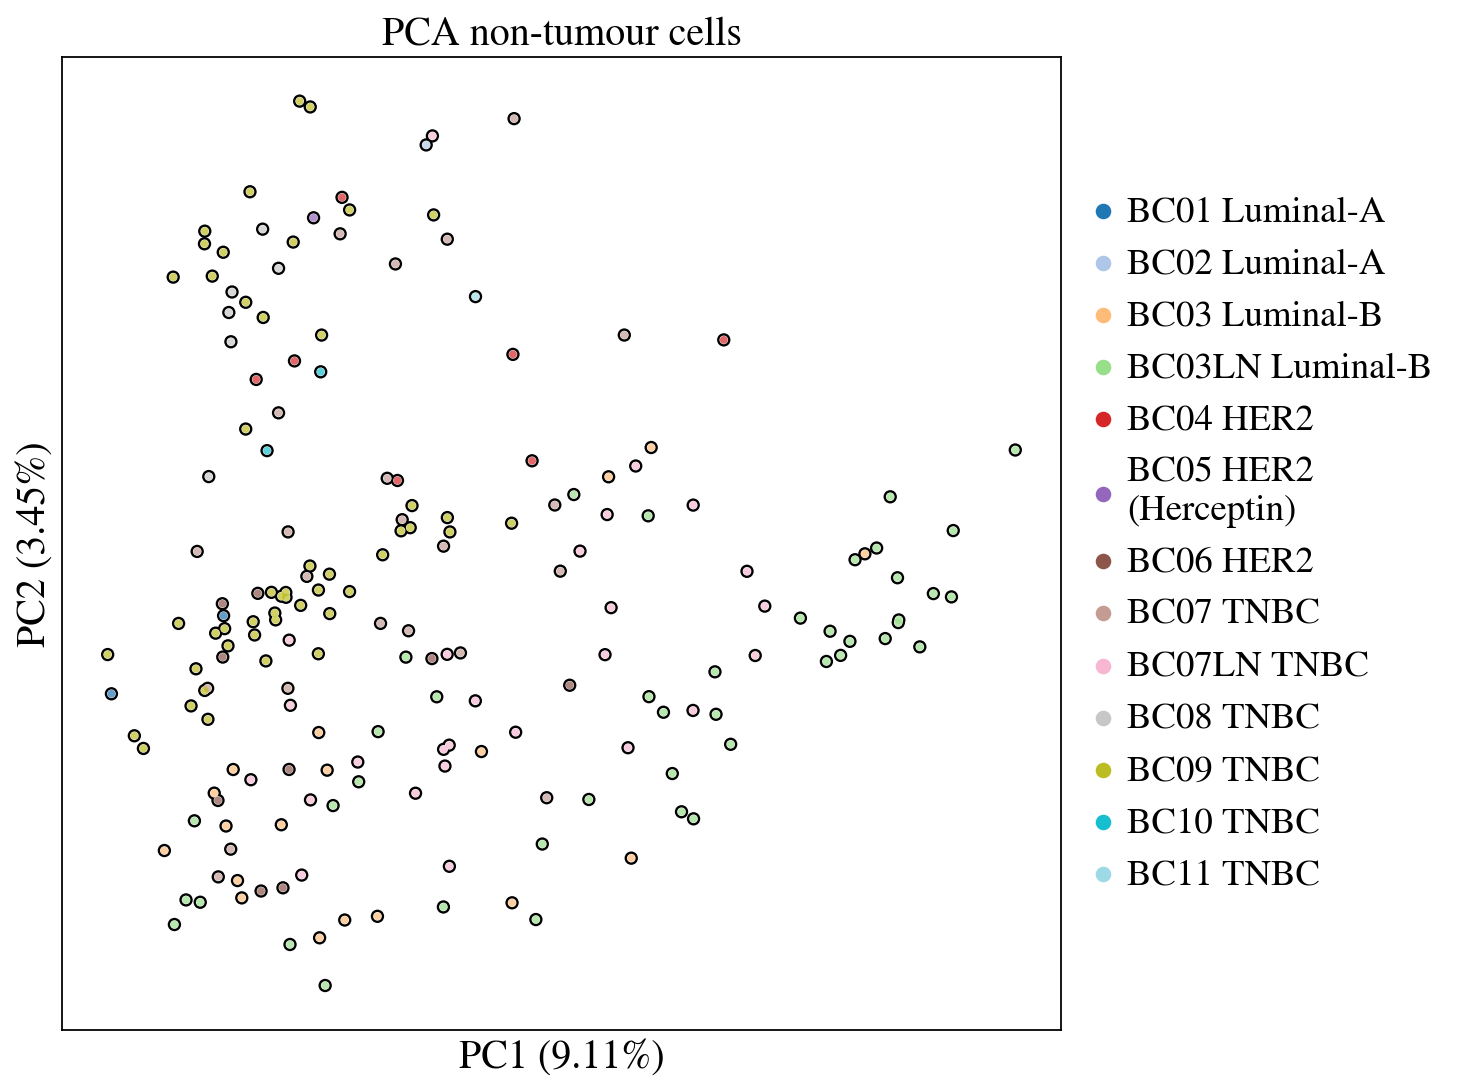

In [ ]:
sc.pp.pca(non_tumour_adata)
sc.pl.pca(non_tumour_adata, color = 'tumor_groups',add_outline=True, size = 50,annotate_var_explained=True,title="PCA non-tumour cells")

**UMAP**

screeplot selected 8 principal components out of 100


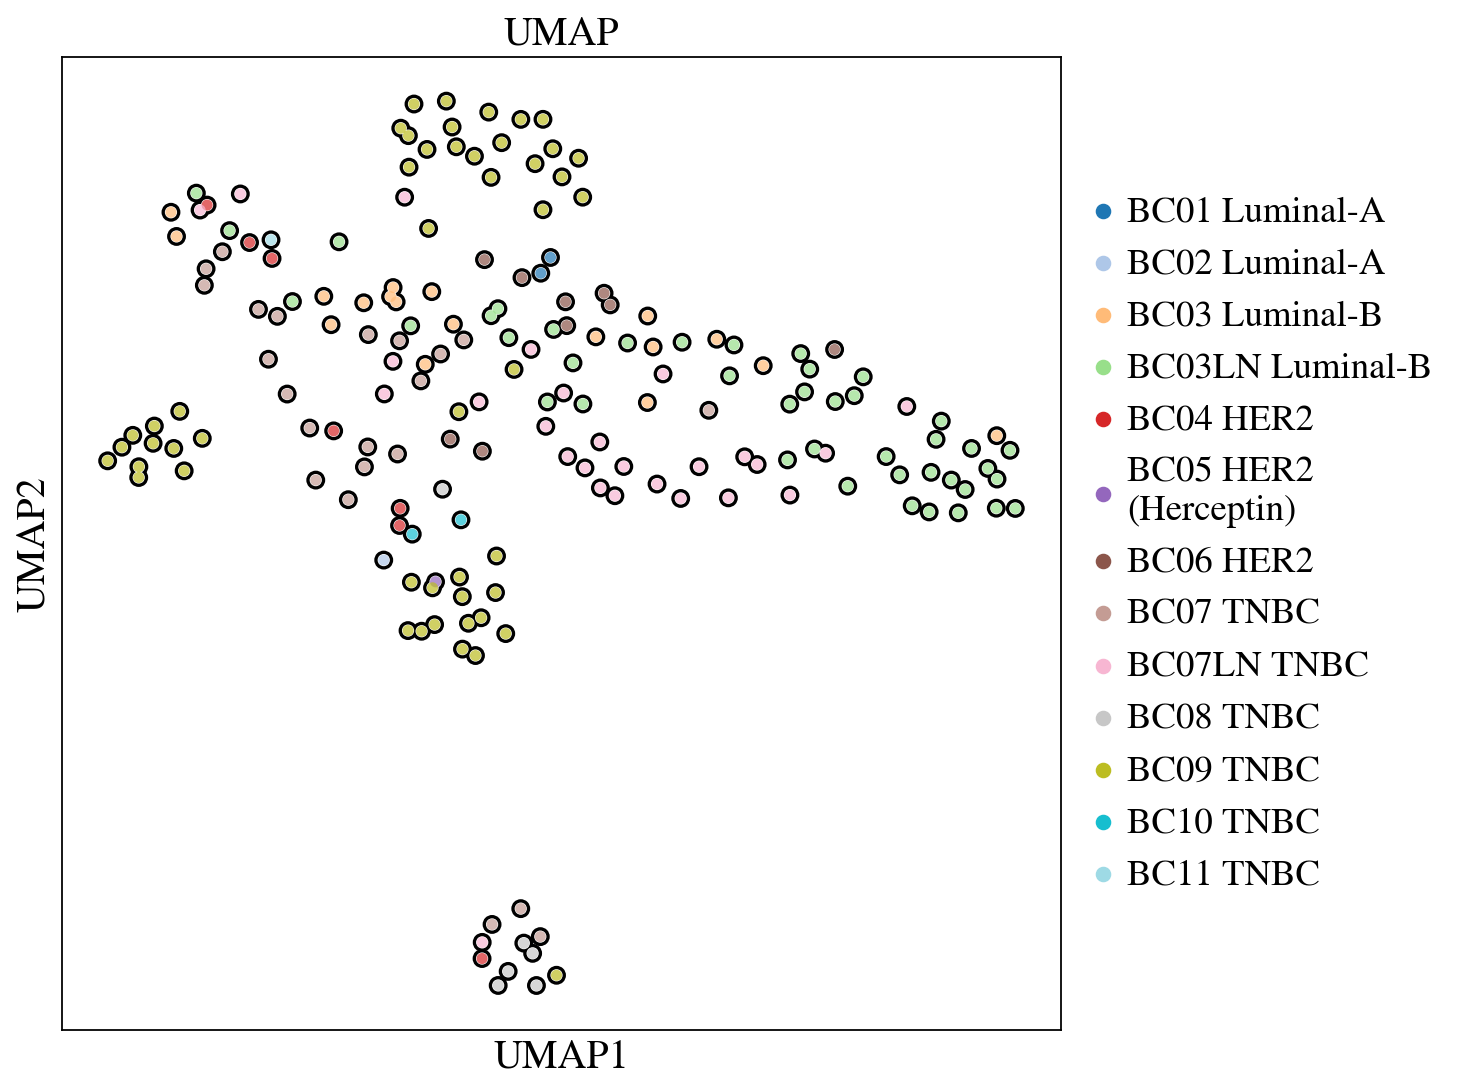

In [ ]:
umap_pipeline = scgmix(adata=non_tumour_adata,rand_seed=42,method="UMAP")
umap_pipeline.dimreduction(pc_selection_method="screeplot",plot_result=True,verbose=True,color="tumor_groups",n_neighbors=15,min_dist=0.75)

**TSNE**

screeplot selected 8 principal components out of 100


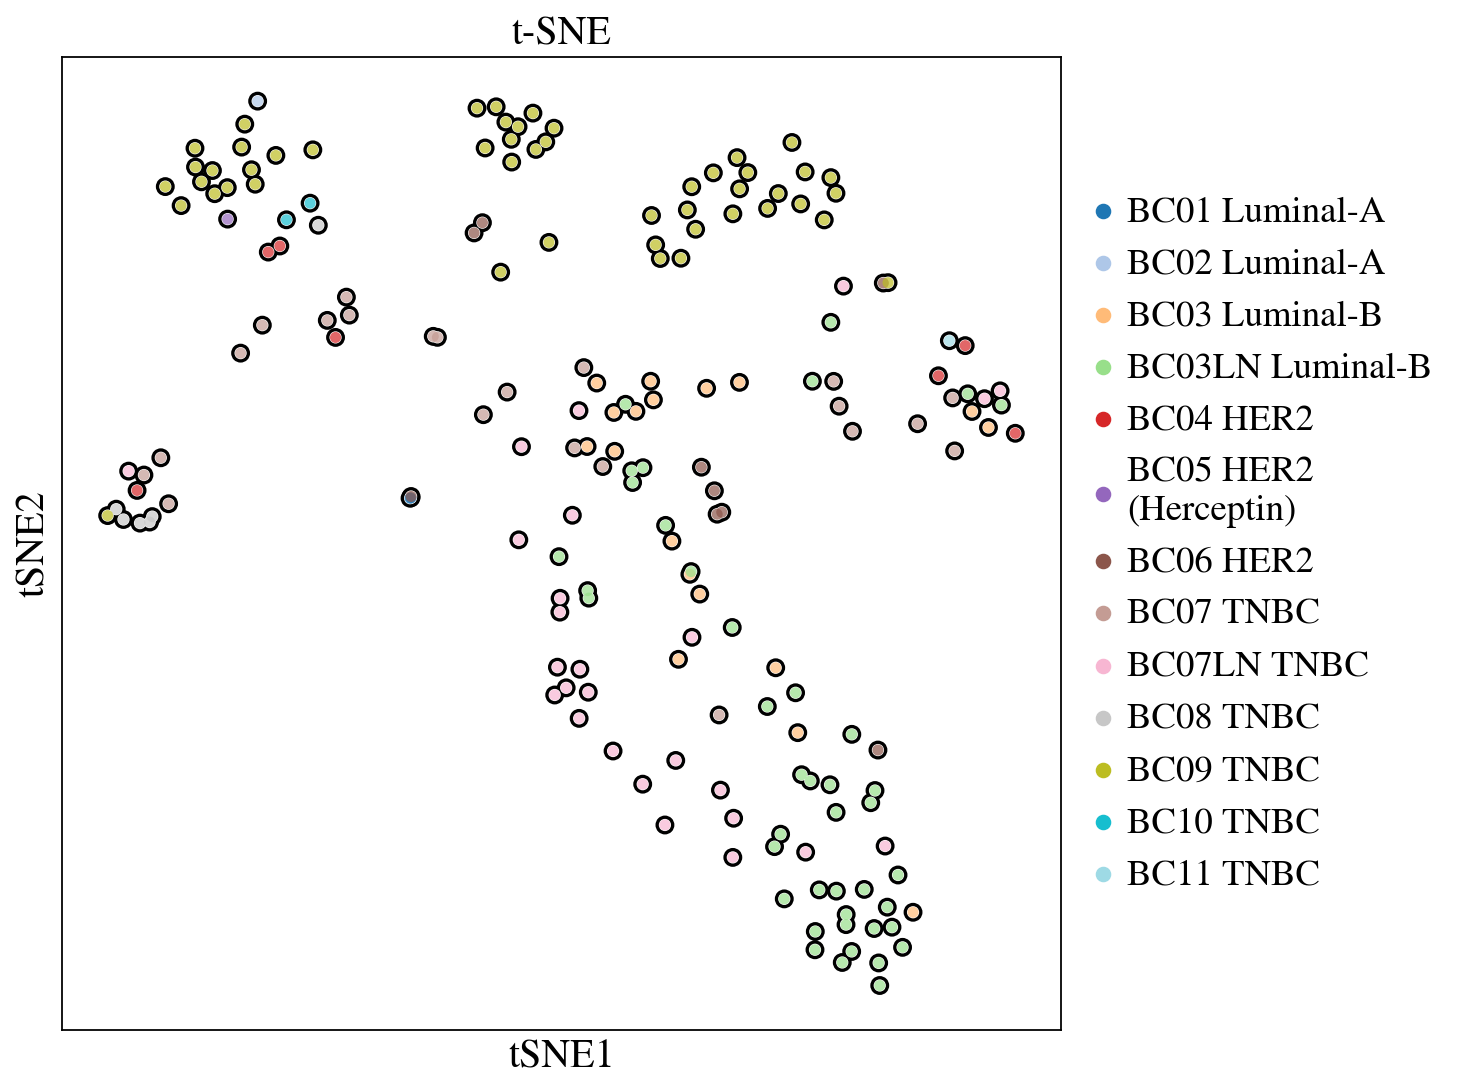

In [ ]:
tsne_pipeline = scgmix(adata=non_tumour_adata,rand_seed=42,method="TSNE")
tsne_pipeline.dimreduction(pc_selection_method="screeplot",plot_result=True,verbose=True,color="tumor_groups",n_neighbors=15,min_dist=0.75)

## **Tumour Cells**

**PCA**

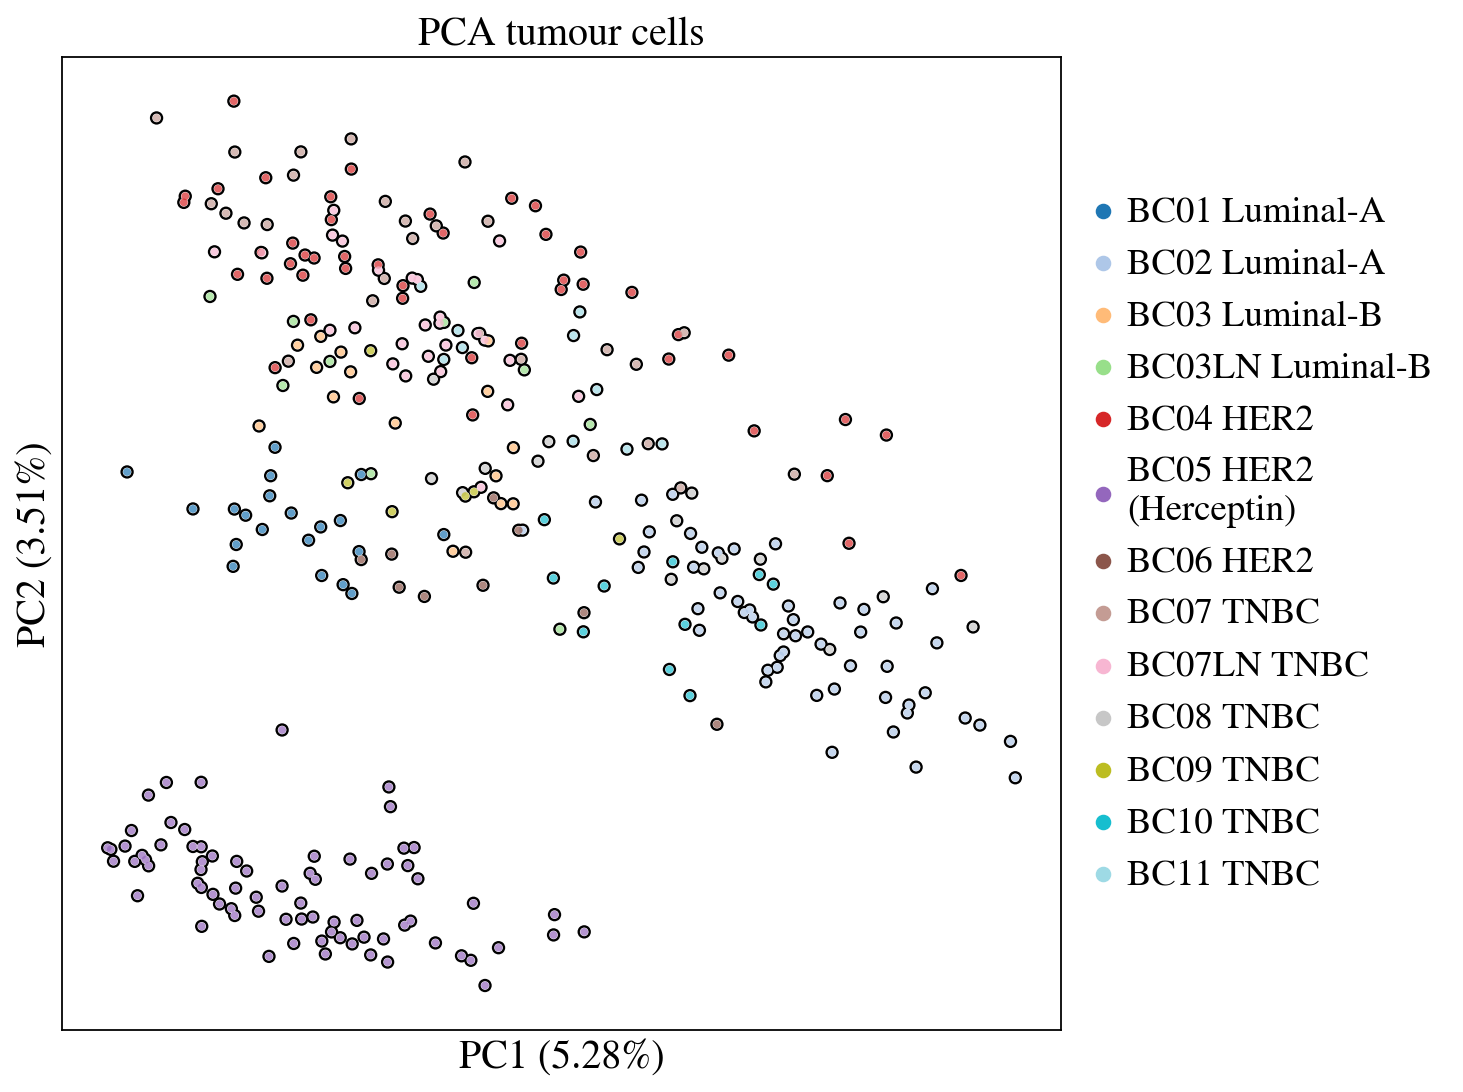

In [ ]:
sc.pp.pca(tumour_adata)
sc.pl.pca(tumour_adata, color = 'tumor_groups',add_outline=True, size = 50,annotate_var_explained=True,title="PCA tumour cells")

**UMAP**

screeplot selected 11 principal components out of 100


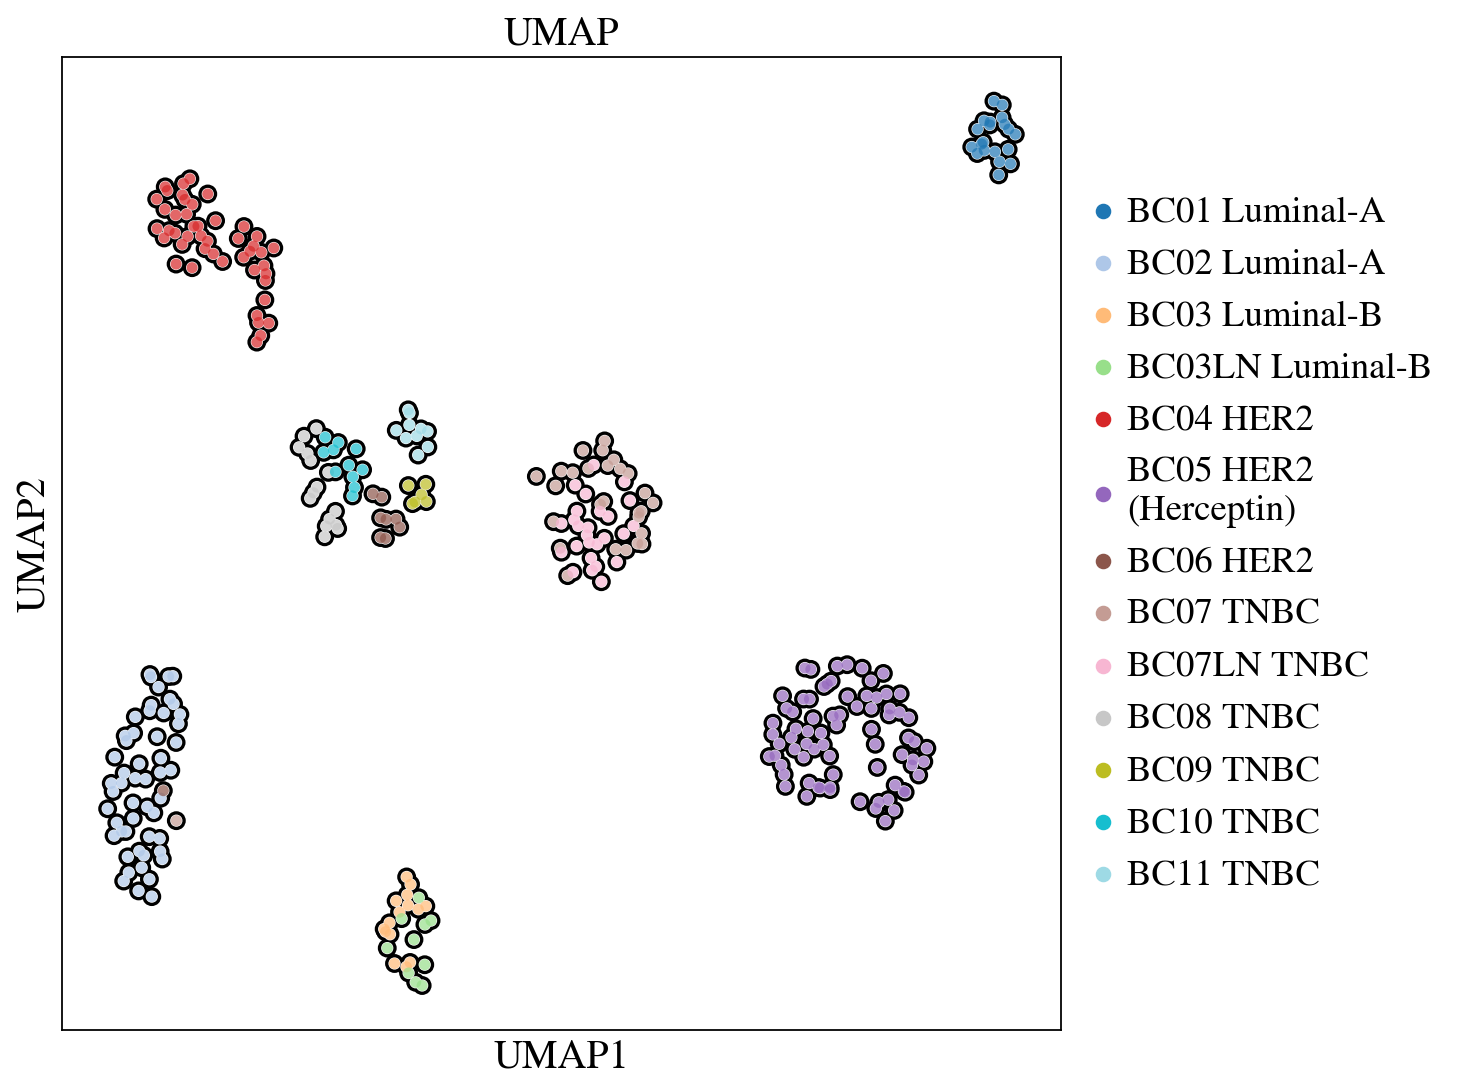

In [ ]:
umap_pipeline = scgmix(adata=tumour_adata,rand_seed=42,method="UMAP")
umap_pipeline.dimreduction(pc_selection_method="screeplot",plot_result=True,verbose=True,color="tumor_groups",n_neighbors=15,min_dist=0.75)

**TSNE**

screeplot selected 11 principal components out of 100


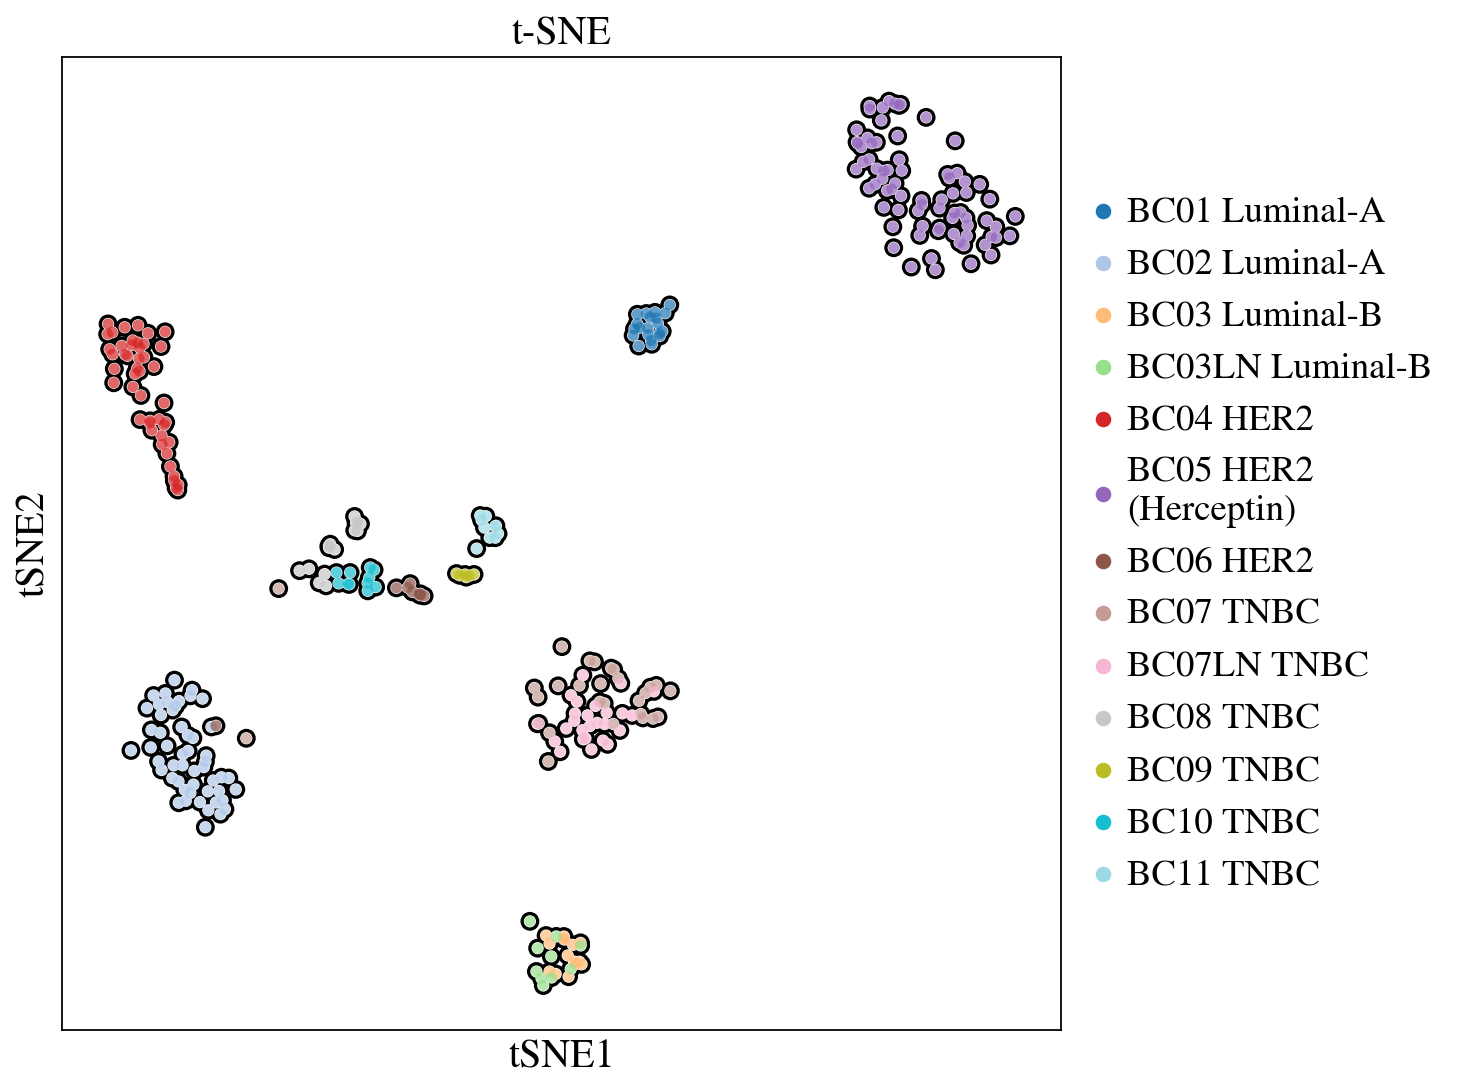

In [ ]:
tsne_pipeline = scgmix(adata=tumour_adata,rand_seed=42,method="TSNE")
tsne_pipeline.dimreduction(pc_selection_method="screeplot",plot_result=True,verbose=True,color="tumor_groups",n_neighbors=15,min_dist=0.75)

In [ ]:
tumour_adata.write("datasets/tumour_cellcounts.h5ad")
non_tumour_adata.write("datasets/nontumour_cellcounts.h5ad")